# Background and Introduction - Problem Statement

Visit With Us is a travel company looking to add a new package to their product selection. In the past, the company has offered 5 different tiers of travel packages and would now like to offer clients the option of a Wellness package. However, in previous years, the company has chosen who to target potential customer through their marketing campaign at random and because of this, the company has incurred in large marketing costs with a low success of conversion. They have now decided to use machine learning to try and target customers which are more likely to accept their package offering.

# Key Factors:
- When the company decided to add a new package tier, they also decided to make use of the data gathered in past years. This means our target variable will be Prodtaken and will use the rest of the columns as predictors.
- Throughout this workbook, we will check for imbalance in our response variable, perform EDA, impute missing values if necessary and do some feature engineering. Once our dataset has been processed and is ready to be fed into our models, we will make use of several different algorithms. Starting from a simple decission tree, using a bagging algorithm, then a random forest and finally using boosting algorithms. 
- From the above, we can pose the problem as follows: We need to target the prospective customers who will most likely accept the package, but we cannot be so specific in our targeting that we miss out in prospectoive clients. (This problem statement will allow us to choose the proper metric when the time comes to choose one).
For each of our models, as always, we will check performance with several different metrics and finally choose our top-performing model. We will also perform cross-validation grid search to check for best parameters, being careful to not overfit our hyperparameters.

In [682]:
# Import all necessary libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

# Classifiers libraries
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

# Metrics libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, precision_recall_curve, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# EDA

In [683]:
# Import dataset and convert into pd dataframe and look at random sample of rows
df = pd.read_excel('Tourism.xlsx', sheet_name='Tourism')
np.random.seed(1)
df.sample(n=30)

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
3015,203015,0,27.0,Company Invited,1,7.0,Salaried,Female,4,6.0,Basic,3.0,Married,5.0,0,4,1,3.0,Executive,23042.0
1242,201242,0,40.0,Self Enquiry,3,13.0,Small Business,Male,2,3.0,King,4.0,Single,2.0,0,4,1,NaN,VP,34833.0
3073,203073,0,29.0,Self Enquiry,2,15.0,Small Business,Male,4,5.0,Basic,3.0,Married,3.0,0,2,0,2.0,Executive,23614.0
804,200804,0,48.0,Company Invited,1,6.0,Small Business,Male,2,1.0,Super Deluxe,3.0,Single,3.0,0,2,0,0.0,AVP,31885.0
3339,203339,0,32.0,Self Enquiry,1,18.0,Small Business,Male,4,4.0,Deluxe,5.0,Divorced,3.0,1,2,0,3.0,Manager,25511.0
3080,203080,1,36.0,Company Invited,1,32.0,Salaried,Female,4,4.0,Basic,4.0,Married,3.0,1,3,0,1.0,Executive,20700.0
2851,202851,0,46.0,Self Enquiry,1,17.0,Salaried,Male,4,4.0,Basic,3.0,Divorced,5.0,0,5,1,1.0,Executive,21332.0
2883,202883,1,32.0,Company Invited,1,27.0,Salaried,Male,4,4.0,Standard,3.0,Divorced,5.0,0,3,1,1.0,Senior Manager,28502.0
1676,201676,0,22.0,Self Enquiry,1,11.0,Salaried,Male,2,1.0,Basic,4.0,Married,2.0,1,4,1,0.0,Executive,17328.0
1140,201140,0,44.0,Self Enquiry,1,13.0,Small Business,Female,2,3.0,King,3.0,Married,1.0,1,4,1,1.0,VP,34049.0


- We can already see some missing values in our dataset, further inspection is required.

In [684]:
# General information about size, shape and type of variables in dataset
df.drop(columns='CustomerID', inplace=True) # We will use pandas Index instead of this ID
print('Types of variables in dataframe:')
print(df.info())
print('\nShape of dataframe:')
print(df.shape)
print('\n5 Point analysis of numerical variables in dataframe:')
print(df.describe().T)
print('\nNumber of null values in dataframe:')
print(df.isnull().sum())

Types of variables in dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ProdTaken                 4888 non-null   int64  
 1   Age                       4662 non-null   float64
 2   TypeofContact             4863 non-null   object 
 3   CityTier                  4888 non-null   int64  
 4   DurationOfPitch           4637 non-null   float64
 5   Occupation                4888 non-null   object 
 6   Gender                    4888 non-null   object 
 7   NumberOfPersonVisiting    4888 non-null   int64  
 8   NumberOfFollowups         4843 non-null   float64
 9   ProductPitched            4888 non-null   object 
 10  PreferredPropertyStar     4862 non-null   float64
 11  MaritalStatus             4888 non-null   object 
 12  NumberOfTrips             4748 non-null   float64
 13  Passport                  4888

- This summary allows us to start working on modifications that have to been performed on our dataset. We have to convert several columns from int or float into categorical values (both ordinal and nominal). We will take a closer look in our next step.
- We see the average age of customers is 37.7 and min value 18, max 61. There are 226 missing values in this column.
- The averga duration of pitch is around 15 minutes, we also have 251 missing values here. Perhaps they refer to 0 minutes, but we need more information.
- We also see that the mean size of visitng group is close to 3 individuals, while the max size of group is 5. Interesting to see the mean number of children per customer is close to 1, and 75th percentile is 2 children. This leads us to belive the compnay usually treats with small sized families and single/couple individuals.
- The average income in our dataset is 23, 619 dollars per month and half of the people earn between 20, 346 and 25 571 dollars. The maximum monthly wage is almost 10k. This leads me to believe the variable is higly skewd and will have to be treated.
- We have 4888 observations total

# Univariate and Bivariate Analysis

In [685]:
# Convert into categorical variables

for i in ['ProdTaken', 'TypeofContact', 'Gender', 'CityTier', 'PreferredPropertyStar', 'PitchSatisfactionScore', 
          'Occupation', 'ProductPitched', 'MaritalStatus','Passport', 'OwnCar', 'Designation']:
    df[i]= df[i].astype('category')

- Note that ProductPitched is an ordinal and not nominal category, luckily for us, our models are capable of learning implicit hierarchy on their own. Similar reasoning can be done with CityTier, PreferredPropertyStar and PitchSatisfactionScore.

# Categorical Variables

0    81.178396
1    18.821604
Name: ProdTaken, dtype: float64
Self Enquiry       70.820481
Company Invited    29.179519
Name: TypeofContact, dtype: float64
1    65.261866
3    30.687398
2     4.050736
Name: CityTier, dtype: float64
Salaried          48.445172
Small Business    42.635025
Large Business     8.878887
Free Lancer        0.040917
Name: Occupation, dtype: float64
Male       59.656301
Female     37.172668
Fe Male     3.171031
Name: Gender, dtype: float64
Basic           37.684124
Deluxe          35.433715
Standard        15.180033
Super Deluxe     6.996727
King             4.705401
Name: ProductPitched, dtype: float64
3.0    61.559029
5.0    19.662690
4.0    18.778281
Name: PreferredPropertyStar, dtype: float64
Married      47.872340
Divorced     19.435352
Single       18.739771
Unmarried    13.952537
Name: MaritalStatus, dtype: float64
0    70.908347
1    29.091653
Name: Passport, dtype: float64
3    30.237316
5    19.844517
1    19.271686
4    18.657938
2    11.988543
Name:

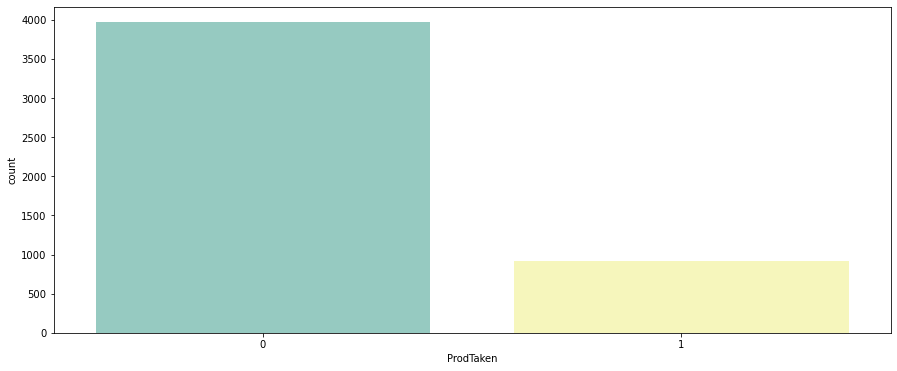

<Figure size 432x288 with 0 Axes>

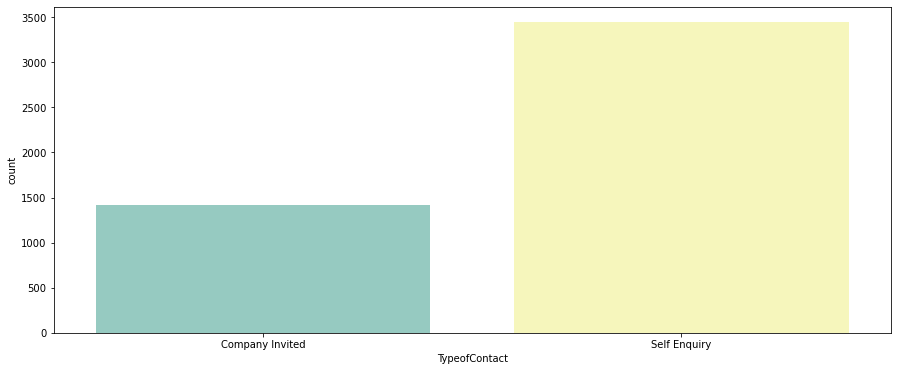

<Figure size 432x288 with 0 Axes>

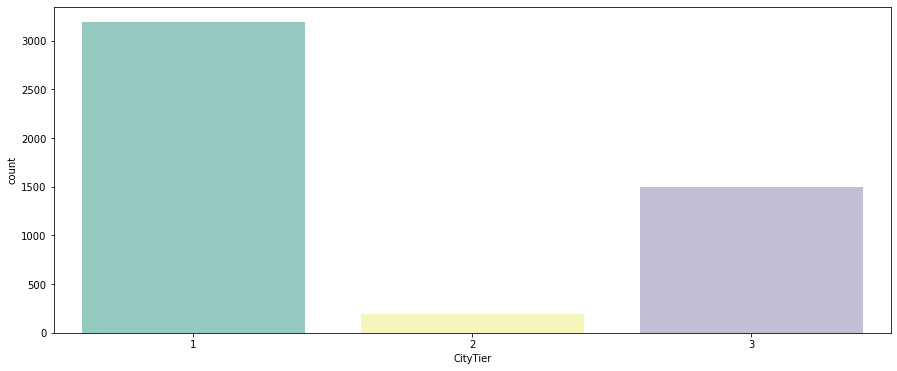

<Figure size 432x288 with 0 Axes>

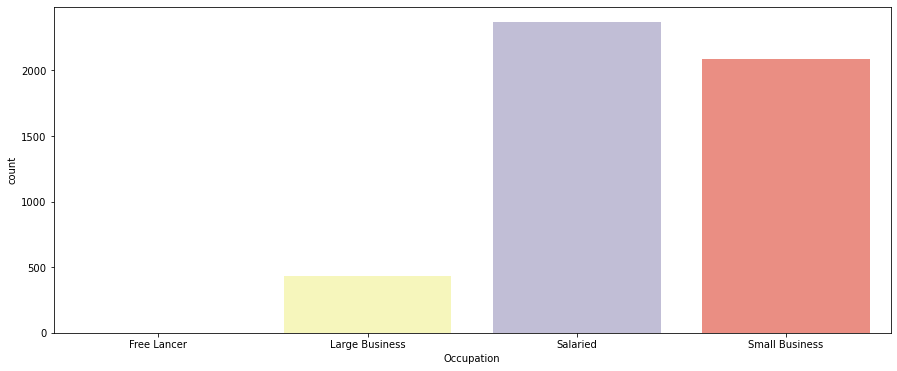

<Figure size 432x288 with 0 Axes>

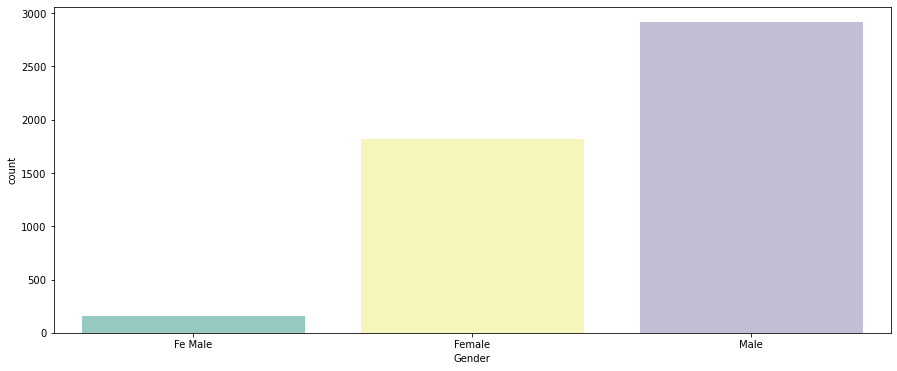

<Figure size 432x288 with 0 Axes>

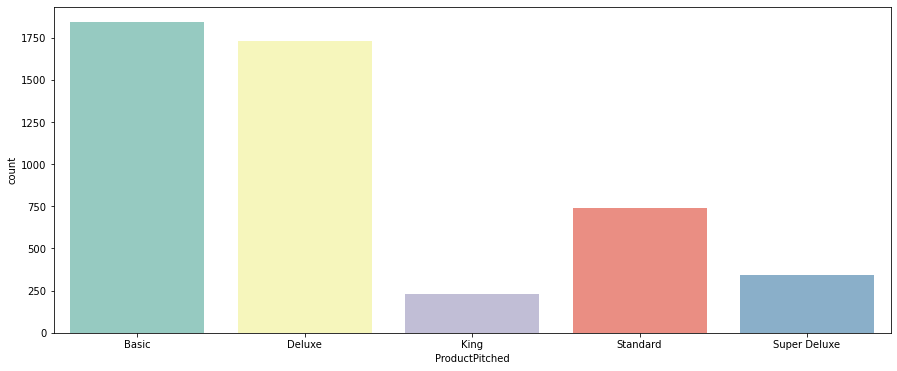

<Figure size 432x288 with 0 Axes>

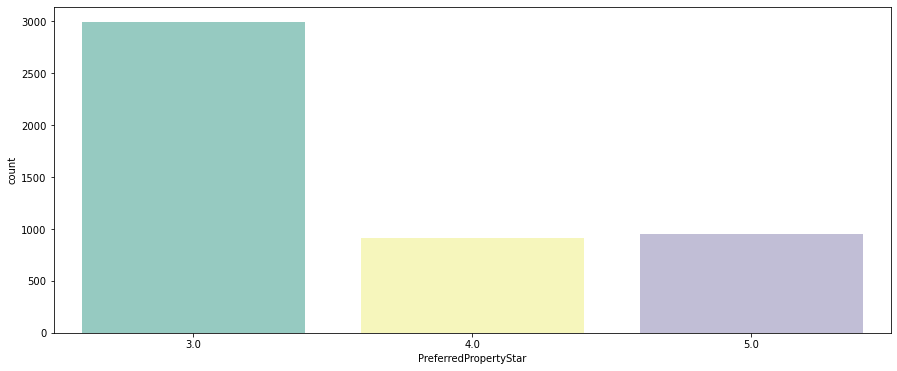

<Figure size 432x288 with 0 Axes>

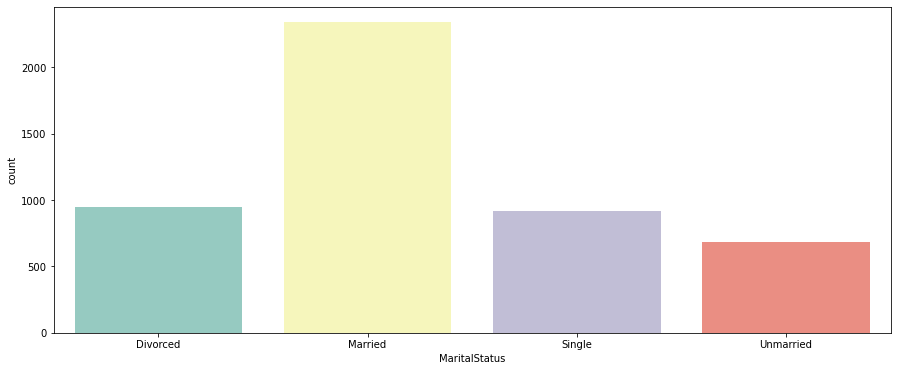

<Figure size 432x288 with 0 Axes>

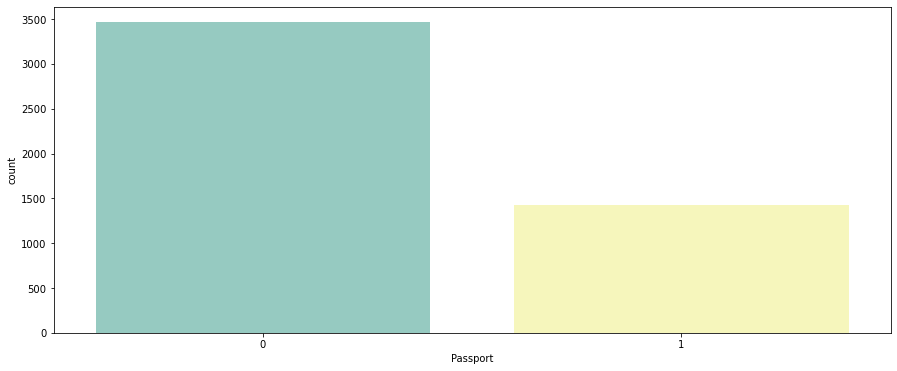

<Figure size 432x288 with 0 Axes>

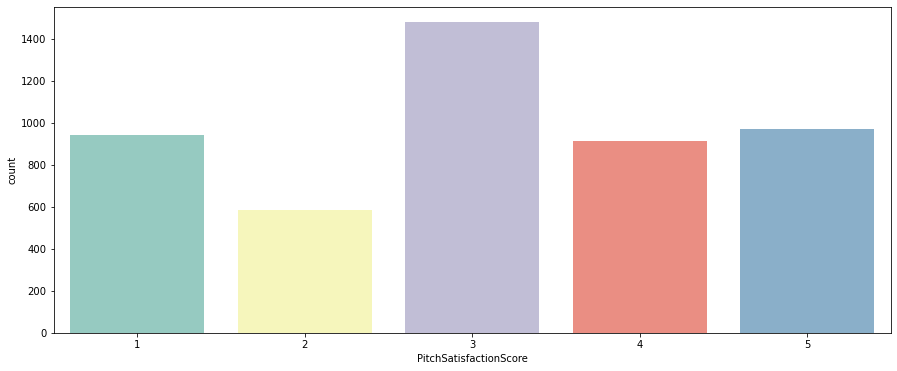

<Figure size 432x288 with 0 Axes>

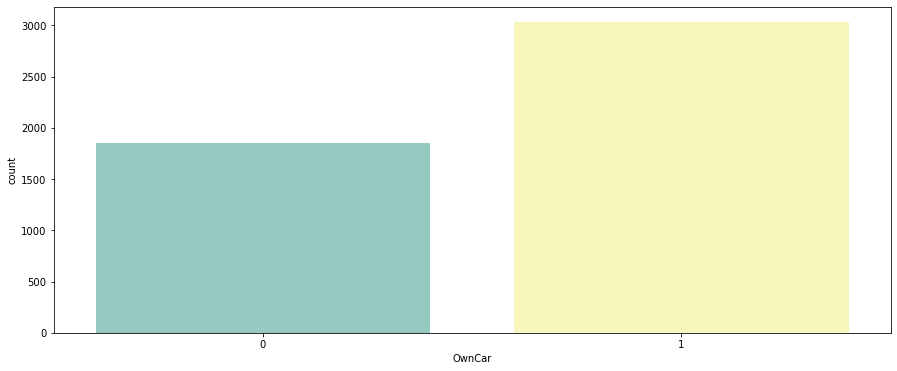

<Figure size 432x288 with 0 Axes>

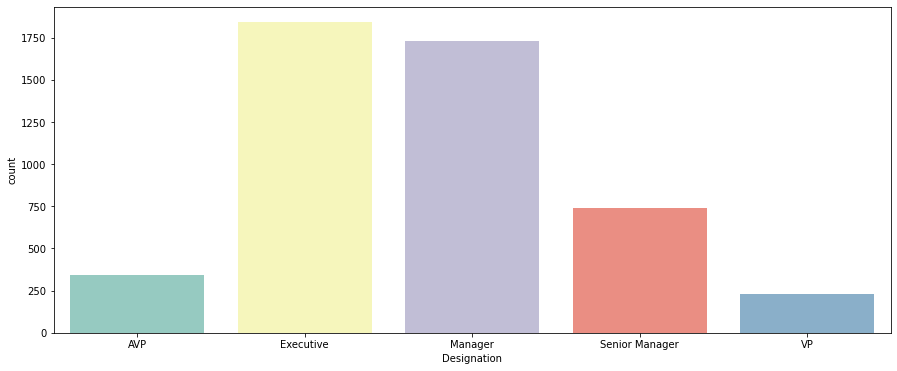

<Figure size 432x288 with 0 Axes>

In [686]:
for i in df.columns[df.dtypes == 'category']:
    plt.figure(figsize=(15,6))
    sns.countplot(df[i],palette="Set3")
    print(df[i].value_counts(normalize=True)*100) # To see percentage composition
    plt.figure()

In [687]:
df.describe(include=['category']).T

,count,unique,top,freq
ProdTaken,4888,2,0,3968
TypeofContact,4863,2,Self Enquiry,3444
CityTier,4888,3,1,3190
Occupation,4888,4,Salaried,2368
Gender,4888,3,Male,2916
ProductPitched,4888,5,Basic,1842
PreferredPropertyStar,4862,3,3,2993
MaritalStatus,4888,4,Married,2340
Passport,4888,2,0,3466
PitchSatisfactionScore,4888,5,3,1478


- 81 Per cent of potential customers did not take the package they were offered. We will have to use stratified training set as to deal with this imbalance in classes.
- We can also see that about 7/10 of contact type were initiated by the customer first and not company invited.
- Almost half of all potential customers are employed, although 42 per cent own a small business. Almost no one is a freelancer, which make up only .04 per cent of the dataset
- Notice we have both Females and Fe Male, this will have to be corrected to have only 2 classes and not 3
- The top 2 most expensive packages are rarely pitch, together they only make up for 10 per cent of all sale pitches
- Note a large majority of customers selected 3 as pitch satisfaction, making up 30 per cent of all selections. An almost equal amount of individuals (20 per cent), either loved the pitch (level 5) or really disliked it (level 1)
- Executives and managers make up the majority of clients\
- Most customers prefer 3 star resorts

In [688]:
print(df.groupby('ProdTaken')['ProductPitched'].value_counts())
print('\nNumber of packages sold:', df[df['ProdTaken'] == 1]['ProductPitched'].value_counts().sum())
print('Unsuccesful sales:', 4888 - 920)

ProdTaken  ProductPitched
0          Deluxe            1528
           Basic             1290
           Standard           618
           Super Deluxe       322
           King               210
1          Basic              552
           Deluxe             204
           Standard           124
           King                20
           Super Deluxe        20
Name: ProductPitched, dtype: int64

Number of packages sold: 920
Unsuccesful sales: 3968


We see out of al 4888 interactions with customers, 920 were succesful sells and 3968 were declined by potential customers

In [689]:
# Lets quickly fix the 'Fe Male' issue we encountered
df['Gender'].replace('Fe Male', 'Female', inplace = True)
df['Gender'].value_counts(normalize=True)

Male      0.596563
Female    0.403437
Name: Gender, dtype: float64

- Now that we have fixed the wording, we can notice 60 per cent of customers are male and 40 per cent are females.

# Univariate Analysis

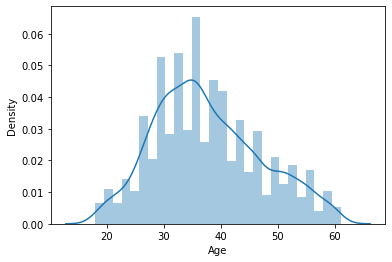

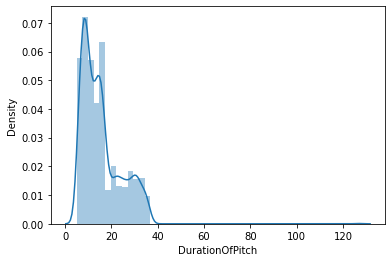

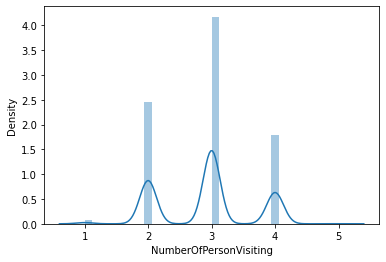

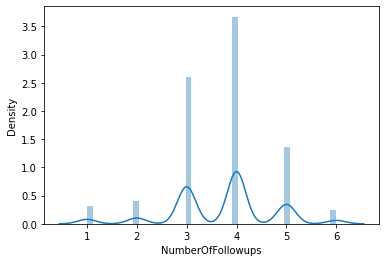

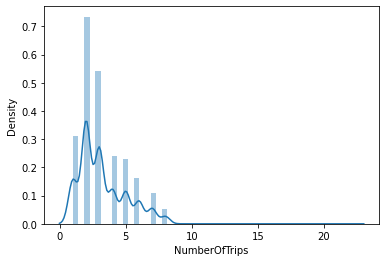

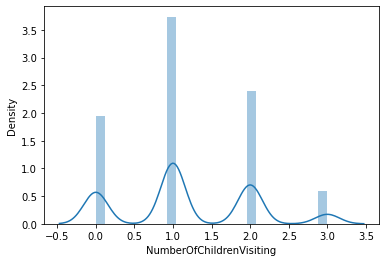

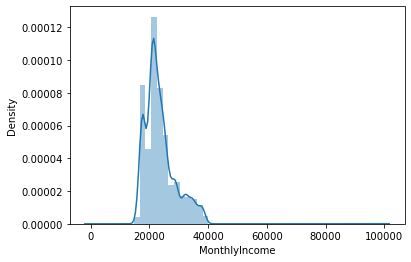

<Figure size 432x288 with 0 Axes>

In [690]:
for i in df.select_dtypes([np.number]).columns:
    sns.distplot(df[i]);
    plt.figure()

- As we can see from our histograms above, MonthlyIncome, NumberOfTrips and DurationOfPitch are somewhat skewd. We will use a log transformation to take care of this problem
- We can also note most customers have 1 child in their families
- And the large majority of individuals have taken less than five trips
- The one child observation makes sense when looking at number of people visiting, since we have most families made up of 3 members

In [691]:
# Log transformation to take care of skewd distributions
for i in ['MonthlyIncome', 'NumberOfTrips', 'DurationOfPitch']:
    df[i]=np.log(df[i])

In [692]:
# We will now make use of the functions from previous lessons and projects to better understand the distribution of each numerical value. This will provide more detailed insight than the above 
# histograms because it also plots a boxplot and shows the mean and median of data. Notice we have applied the lof tranformation on our highly skewed variables, so this way we will also see
# if that worked properly.

def histogram_boxplot(feature, figsize=(10,8), bins = None):
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.15, .85)}, 
                                           figsize = figsize 
                                           ) # These are the options for how the 2 plots will look in a single image
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='white') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='-') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='blue', linestyle='dashdot') # Add median to the histogram

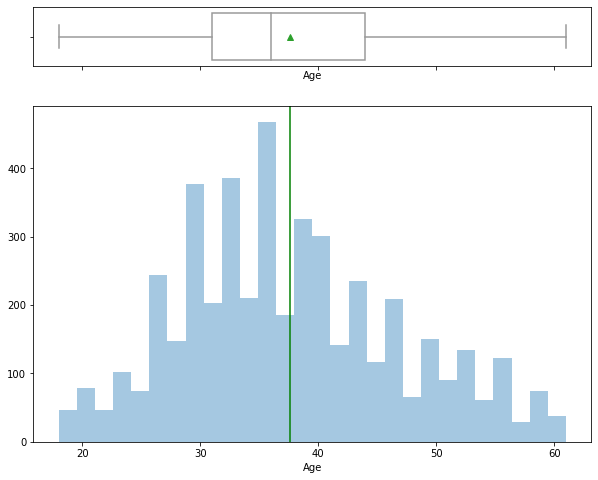

In [693]:
histogram_boxplot(df['Age'])

- We notice age is not perfectly normally distributed, however, it is not so highly skewed that we would have to apply log tranformation on it. We see a little positive skew, which is good news because younger customers are more likely to get the package!
- Mean age for whole group is about 37 and meadian a bit lower, at 35.

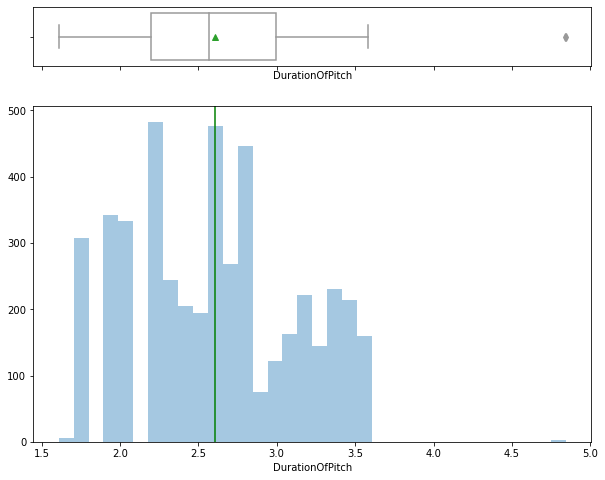

In [694]:
histogram_boxplot(df['DurationOfPitch'])

- The log tranformation did help lower the skeweness of our variable, but it doesn't resemble a normal distribution, it looks more like a continous uniform distribution, although not perfectly uniform.
- Mean and median log(DuratioOfPitch) hover around 2.65 and 2.7, respectively. 

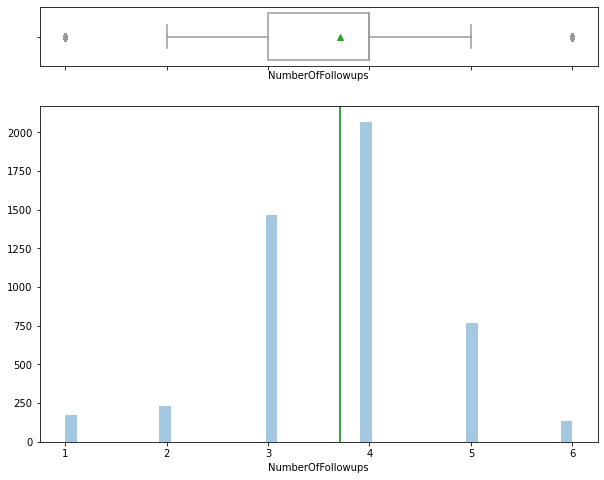

In [695]:
histogram_boxplot(df['NumberOfFollowups'])

We see a slight positive skew in this histogram, with median being slightly higher than the mean. And most importantly, the mode is clearly 4 followup calls, as well as the median. The mean is a bit lower at 3.75 followup calls or so.

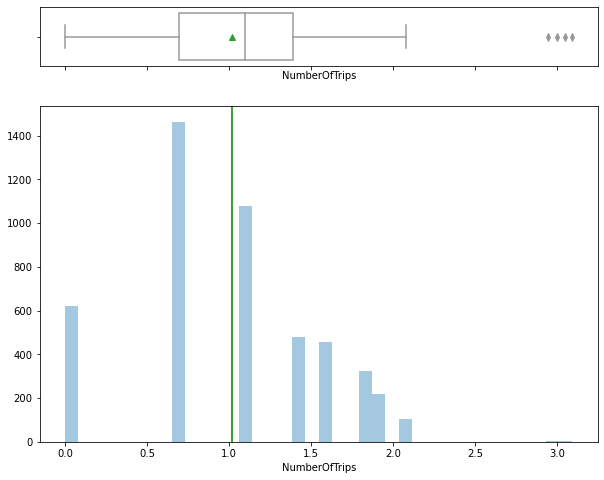

In [696]:
histogram_boxplot(df['NumberOfTrips'])

- Again, our log transformation has certainly reduced the amount of skew in our variable. However, there is still a noticeable skew. We also note that for most clients this will not be their first trip. This could play a factor in our modeling. 
- Interestingly enough, we can notice that 50 per cent or so of our prospective clients have already taken trips before, but there is a percentage of them that have taken 0 trips as well.

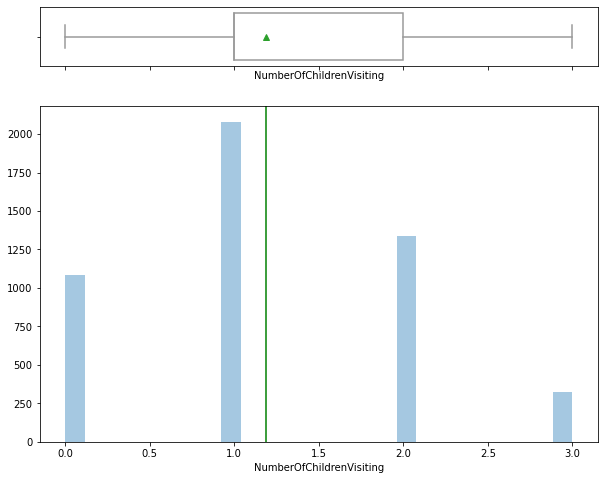

In [697]:
histogram_boxplot(df['NumberOfChildrenVisiting'])


- We see a slight skew in the number of children visiting, but not large enough to grant a log transformation. However, notice that most families have only one child, whoch is common in this day and age, when people are starting to have less children because of the high costs. It would be interesting to see data from a couple of decades ago and compare.
- The meadina as well as mode is clearly one child visiting with each family, but mean is at 1.2.

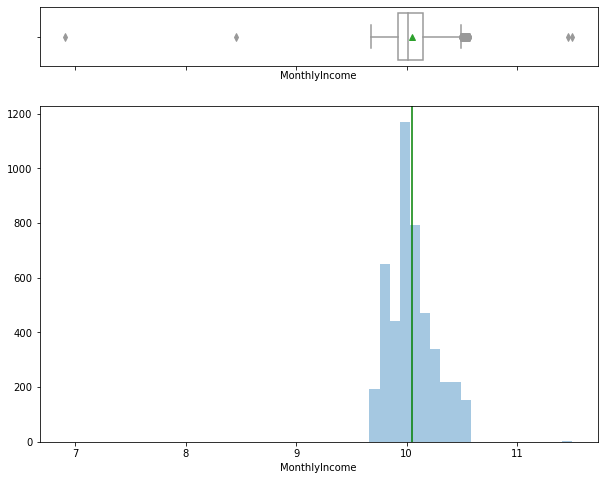

In [698]:
histogram_boxplot(df['MonthlyIncome'])

We have made our data more normally distributed, however there are a few things to note after the tranformation. We seem to have three earnings cohorts. We can notice a normal distribution for the first group which centers around 9.75, and then a small gap before seeing a high spike at 9.99. As is common in most countries, a very selected group of individuals earns much more than other, exemplifies by the lone bar at 10.55.

# Bivariate Analysis and Relationship Between Variables (Heatmap, Hue Plots, Groupby's)

In [699]:
# Let's look again at our categorical variables but differentiate by our response varibale, that is, group by those that
# took the package, and those who didn't

for i in df.columns[df.dtypes == 'category']:
    print(df.groupby('ProdTaken')[i].value_counts(normalize=True))

ProdTaken  ProdTaken
0          0            1.0
1          1            1.0
Name: ProdTaken, dtype: float64
ProdTaken  TypeofContact  
0          Self Enquiry       0.718956
           Company Invited    0.281044
1          Self Enquiry       0.661941
           Company Invited    0.338059
Name: TypeofContact, dtype: float64
ProdTaken  CityTier
0          1           0.672883
           3           0.288810
           2           0.038306
1          1           0.565217
           3           0.384783
           2           0.050000
Name: CityTier, dtype: float64
ProdTaken  Occupation    
0          Salaried          0.492440
           Small Business    0.428427
           Large Business    0.079133
1          Salaried          0.450000
           Small Business    0.417391
           Large Business    0.130435
           Free Lancer       0.002174
Name: Occupation, dtype: float64
ProdTaken  Gender
0          Male      0.589214
           Female    0.410786
1          Male      0.628

There is a lot of information here, let us unwind and note the most interesting observations. As we have proved before (last project), in cases where the percentage differs by a large amount between those who took the package and those who didn't, it is safe to say that feature will have a relatively high importnace. Of course, this seems logical once we realize knowing that feature allows us to achieve a lower Gini coefficent (or entropy), whichever measure you like more.

- We can see a differnece in distribution between those that were company invited and those who were not. This makes sense as it is possible the company had a better prepared pitch when they initaite contact
- Not surprisingly, most customer come from city tier 1, which are the bigger cities and the ones with more accumulated wealth
- We notice a similar distribution between type of employment in both groups, this variable will probably not have too much of a large weight in our models. Similar case with Genre, although it seems most customeers are male in both cases
- As one would expect, the probability that the sales pitch was succesful increases as the type of package decreases, in both cases the majority of customers graded 3 in PitchSatisfaction, but the second most common grade for those that accpeted was 5. Moreover, clearly customers are more willing to spend in a cheaper package than in an expensive one. This variable will probably be important in our models
- Single individuals are also more likely to take the package from this preliminary analysis
- Not having a passport also seems to be related to a higher probability of not having bought the package, this makes lots of logical sense. Perhaps some packages are offered outside of the country
- Finally, almost double the percentage of Execuitives can be found in the group that accepted the package. This dummy varibale will probably carry quite a bit of weight as well.

In [700]:
# We will now do the same for numerical values but will first show difference in means and then a pairplot with hue

df.groupby('ProdTaken').mean().T

ProdTaken,0,1
Age,38.282092,34.770548
DurationOfPitch,2.583775,2.697435
NumberOfPersonVisiting,2.901714,2.919565
NumberOfFollowups,3.654286,3.941886
NumberOfTrips,1.015612,1.025949
NumberOfChildrenVisiting,1.184190,1.200438
MonthlyIncome,10.060786,9.987157


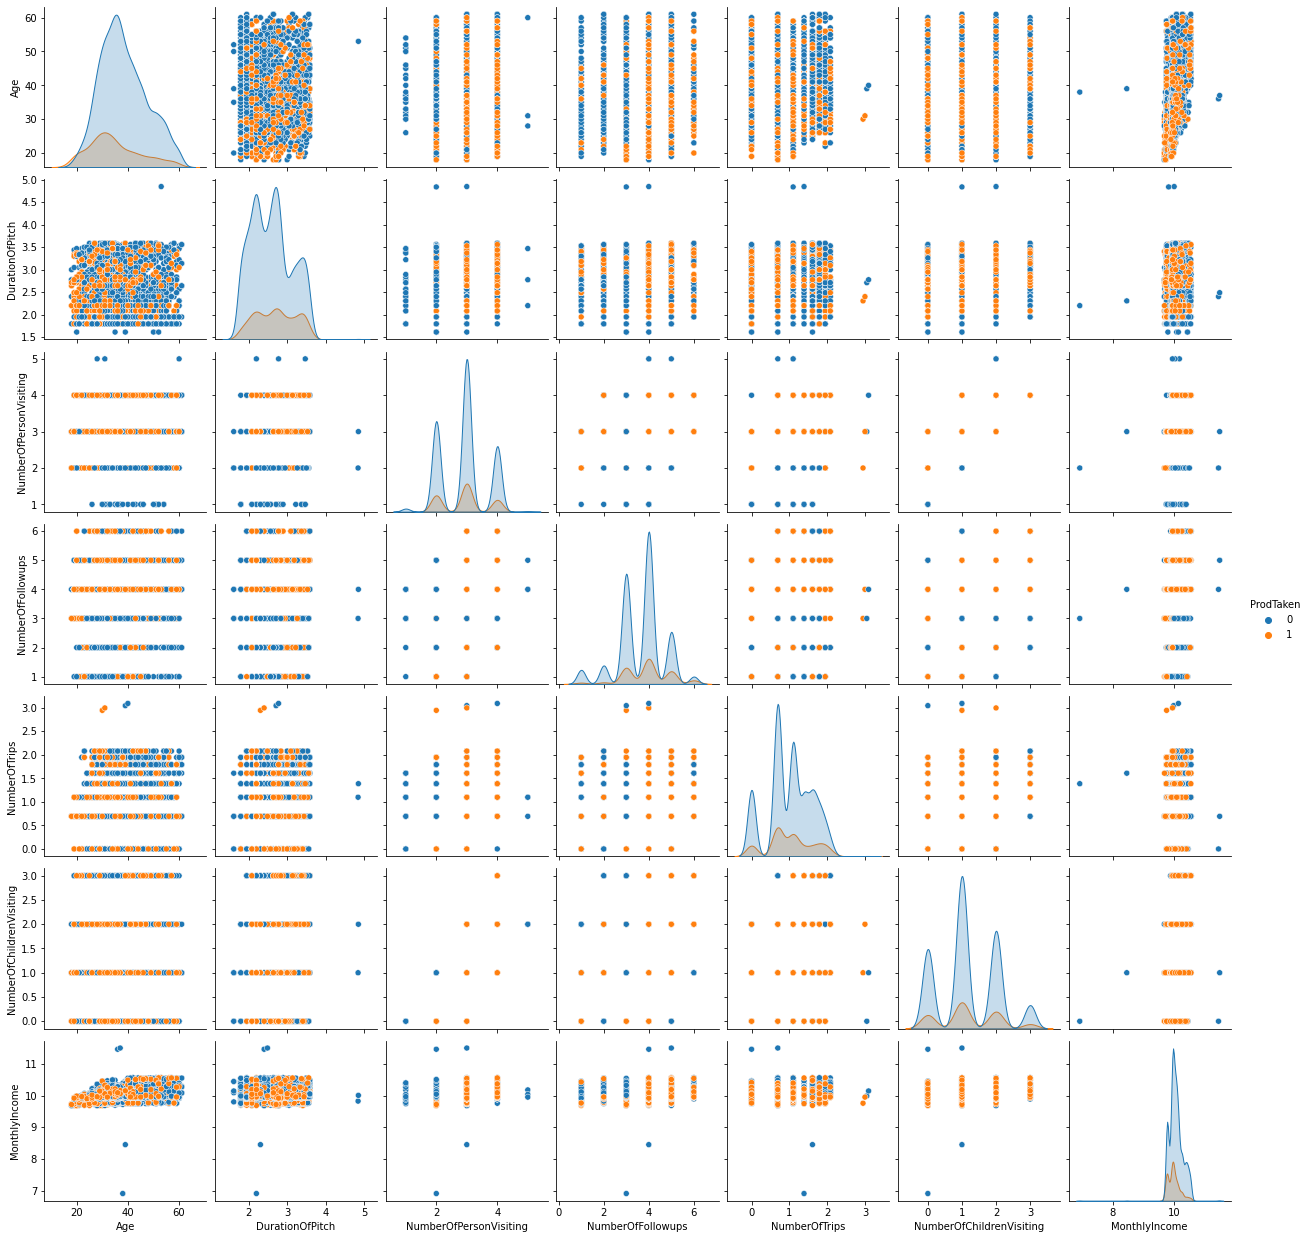

In [701]:
sns.pairplot(df, x_vars=['Age', 'DurationOfPitch', 'NumberOfPersonVisiting', 
                         'NumberOfFollowups', 'NumberOfTrips', 'NumberOfChildrenVisiting', 'MonthlyIncome'],
             y_vars=['Age', 'DurationOfPitch', 'NumberOfPersonVisiting', 
                         'NumberOfFollowups', 'NumberOfTrips', 'NumberOfChildrenVisiting', 'MonthlyIncome'],
             hue='ProdTaken')

This summary of means adn pairplot with hues has provided some unexpected insights.
- The monthly income for those that accepted the package is actually a percentage point lower than those who did not. In reality this is probably not statistically different but is important to note, we will group by package type and see if there are further differences.
- The average number of follow up calls is higher for those that accepted. Furthermore, the pairplot shows us that at least two follow up calls were required for people to accept the trip, interesting indeed!
- Age of those who accepted is certainly lower than those that didn't. 38 years old vs 34 years old
- The duration of ptch also seems to be a bit higher for those that aacepted

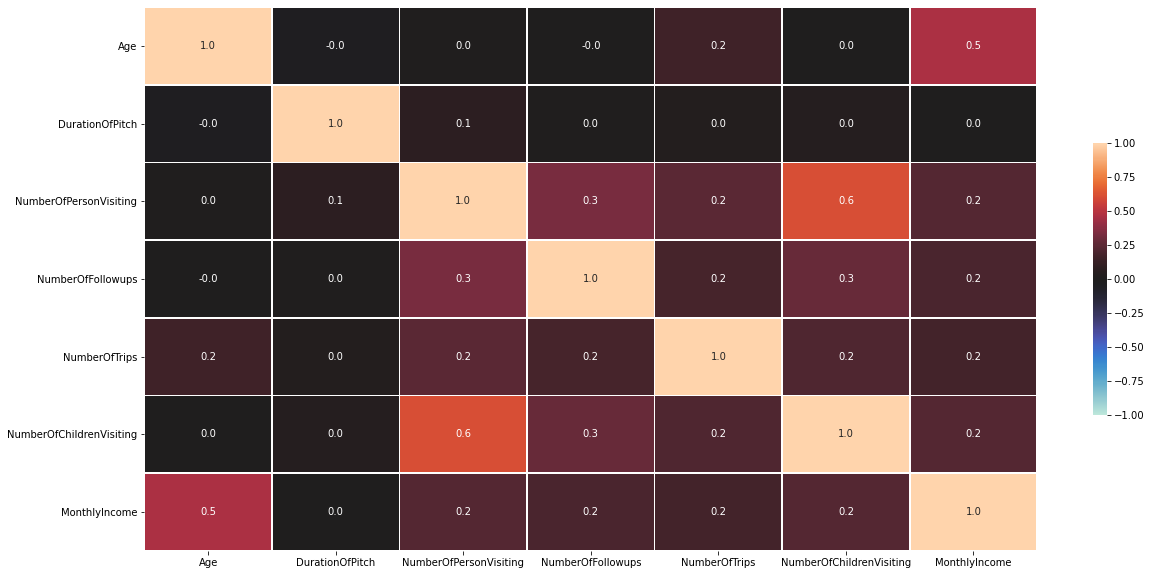

In [702]:
# A heatmap will allows us to see any correlations between variables more easily

numeric_columns = df.select_dtypes(include=np.number).columns.tolist() # Select only numeric columns and drop Year
corr = df[numeric_columns].corr()

f, ax = plt.subplots(figsize=(20, 10)) #Set heatmap size

sns.heatmap(corr, annot=True,fmt=".1f",vmin=-1, vmax=1, center= 0, square=False, linewidths=.7, cbar_kws={"shrink": .5});

There does not seem to be any kind of strong correlation between our varibales. The highest correlation in our dataset is between NumberOfPersonsVisiting and NumberOfChildrenVisiting, which is and observation we made in the last step with help of our histgrams.

AxesSubplot(0.125,0.125;0.775x0.755)


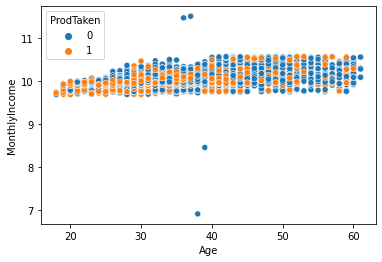

In [703]:
# Let us look at the relationship between Age and MonthlyIncome more closely
print(sns.scatterplot(x='Age', y='MonthlyIncome', data=df, hue='ProdTaken'))

AxesSubplot(0.125,0.125;0.775x0.755)


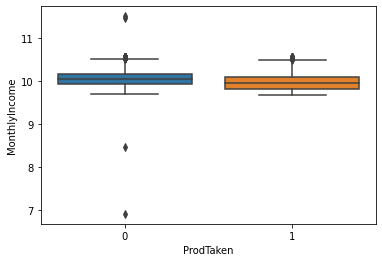

In [704]:
print(sns.boxplot(x='ProdTaken', y='MonthlyIncome', data=df))

While there is subtle linear relationship between our two variables, what we can note, and corroborates earlier findings, is the fact that younger people are more likely to accept the package than older folk! This helps us understand why income for those who took the package is lower!

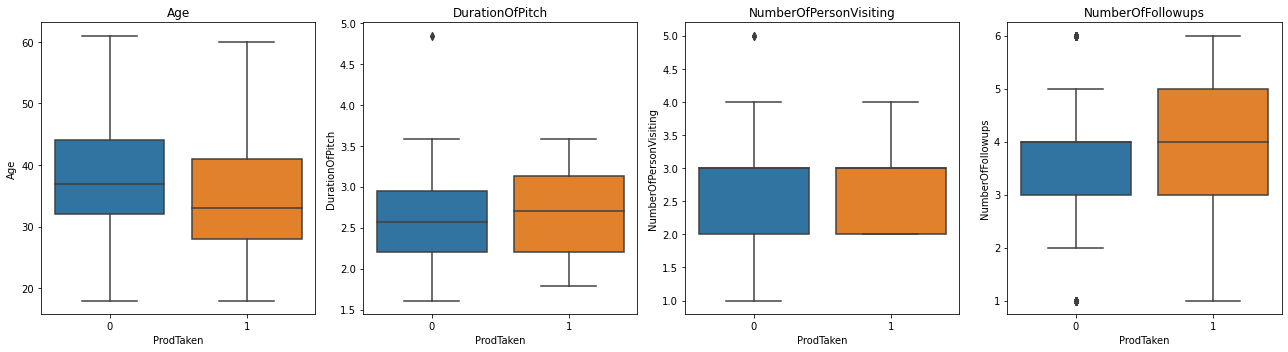

In [705]:
cols = df[['Age', 'DurationOfPitch', 'NumberOfPersonVisiting', 'NumberOfFollowups']].columns.tolist()
plt.figure(figsize=(18,5))

for i, variable in enumerate(cols):
                     plt.subplot(1,4,i+1)
                     sns.boxplot(df['ProdTaken'],df[variable], palette="tab10")
                     plt.tight_layout()
                     plt.title(variable)
plt.show()

This boxplot helps us again, corroborate what we noted earlier, albeit in a more fashionable visualization. Younger customers are more likely to take the package, a longer duration of pitch is associated with having accpeted the package as well as a higher number of follow-ups. In the next part we will take a deeper dive and see how this metrics differ by ProductPitch, which will allow us to create a customer profile!

<AxesSubplot:xlabel='ProductPitched', ylabel='count'>

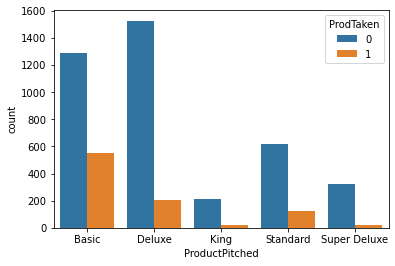

In [706]:
sns.countplot(x="ProductPitched", hue="ProdTaken", data=df)

Here we can note the Deluxe package is the one individuals are most interested in but has a low success rate. While the basic package is the second most popular but with a high success rate. Perhaps the compnay should position their new package between those 2 price segments.

In [707]:
#Let us see if there is a difference in package distribution accepted when contact is made by compnay vs when customer call first!
dfcu = df[df['TypeofContact'] == 'Self Enquiry']
dfco = df[df['TypeofContact'] == 'Company Invited']

AxesSubplot(0.125,0.125;0.775x0.755)


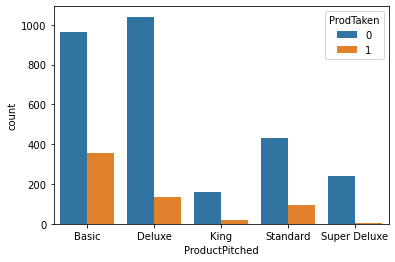

In [708]:
print(sns.countplot(x="ProductPitched", hue="ProdTaken", data=dfcu))

AxesSubplot(0.125,0.125;0.775x0.755)


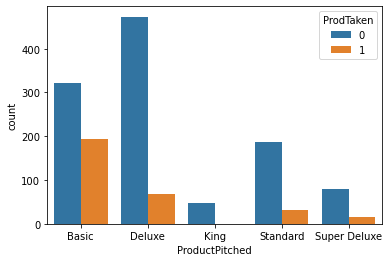

In [709]:
print(sns.countplot(x="ProductPitched", hue="ProdTaken", data=dfco))

AxesSubplot(0.125,0.125;0.775x0.755)


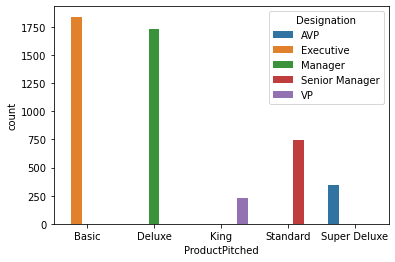

In [710]:
print(sns.countplot(x="ProductPitched", hue="Designation", data=df))

We do have some interesting findings here. King tier seems to be bought mostly when client initiates contact. On the other hand, Super Deluxe is preferred when company's agent initiates sales pitch. I am making a prediciton that our models will give high importance to this feature. We can also see packages are pitched by Designation. That means, product pitched to Executives is the Basic Package, Deluxe for managers, Standard for Senior managers, Super deluxe for AVP and finally, King gets offered to VP's. Do note the package offered to senior managers should be higher than managers, this could have been a data intake mistake. However, since each package is represented by each designation, this will not affect our models.

In [711]:
# Here we can see the relationship (ore differences) between our to target variable groups, that is, those who accepted and those who didn't
for i in df.select_dtypes([np.number]).columns:
    print(df.groupby(['ProdTaken', 'ProductPitched'])[i].mean())

ProdTaken  ProductPitched
0          Basic             33.822485
           Deluxe            37.346869
           King              47.985714
           Standard          40.496764
           Super Deluxe      48.307453
1          Basic             31.289320
           Deluxe            37.641414
           King              48.900000
           Standard          41.008130
           Super Deluxe      43.500000
Name: Age, dtype: float64
ProdTaken  ProductPitched
0          Basic             2.568736
           Deluxe            2.608364
           King              2.411716
           Standard          2.605366
           Super Deluxe      2.608795
1          Basic             2.636573
           Deluxe            2.823974
           King              2.294148
           Standard          2.818424
           Super Deluxe      2.836747
Name: DurationOfPitch, dtype: float64
ProdTaken  ProductPitched
0          Basic             2.940310
           Deluxe            2.883508
           K

- We are obtaining some useful insight from this double grouping that will help us create a customer profile. We see that as the level of package increases, so does the average age of the customer.
- Of course, it would make sense that younger people would opt for a cheaper package, and this is corroborated by the fact that avergae income also seems to increase with package chosen. This can be more easily visualized with a boxplot.
- Interestingly, King has the lowest average call lenght, might this be because they are more decisive? 

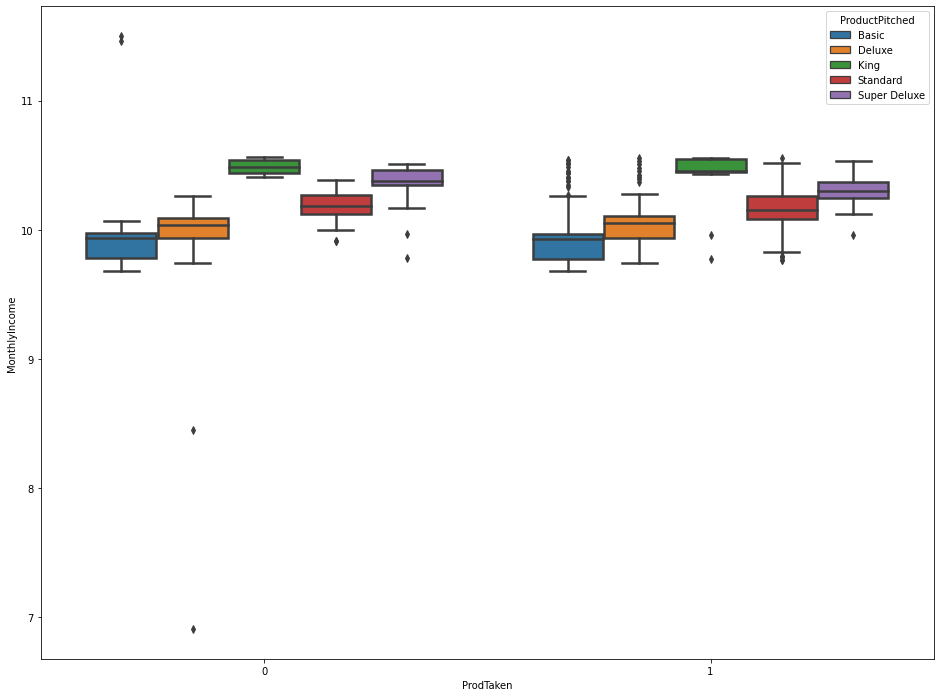

In [712]:
plt.figure(figsize=(16, 12))
sns.boxplot(df['ProdTaken'],df['MonthlyIncome'],hue=df['ProductPitched'], linewidth=2.5)
plt.show()


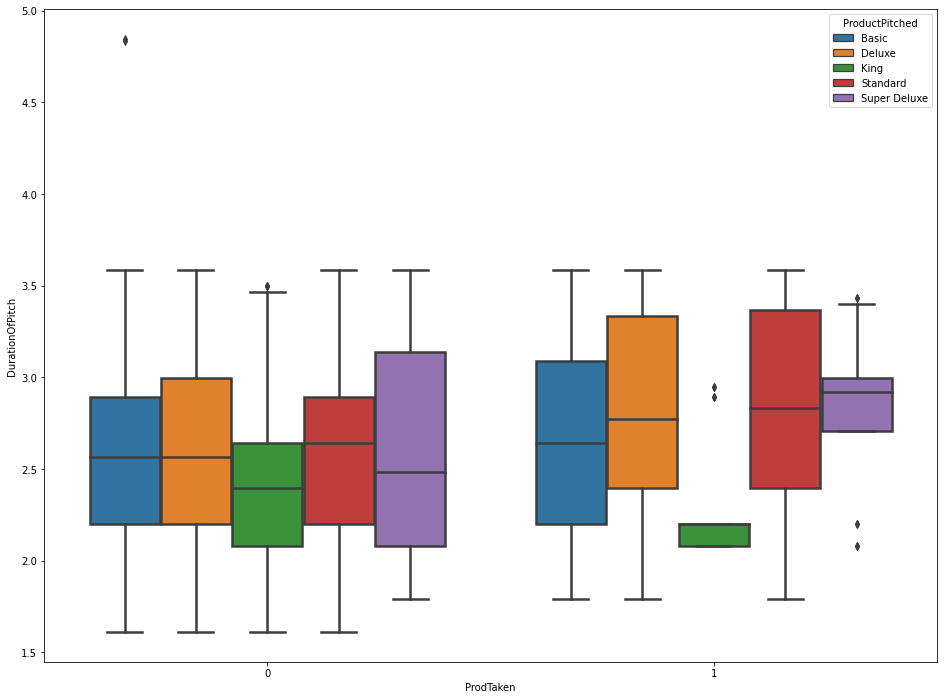

In [713]:
plt.figure(figsize=(16, 12))
sns.boxplot(df['ProdTaken'],df['DurationOfPitch'],hue=df['ProductPitched'], linewidth=2.5)
plt.show()


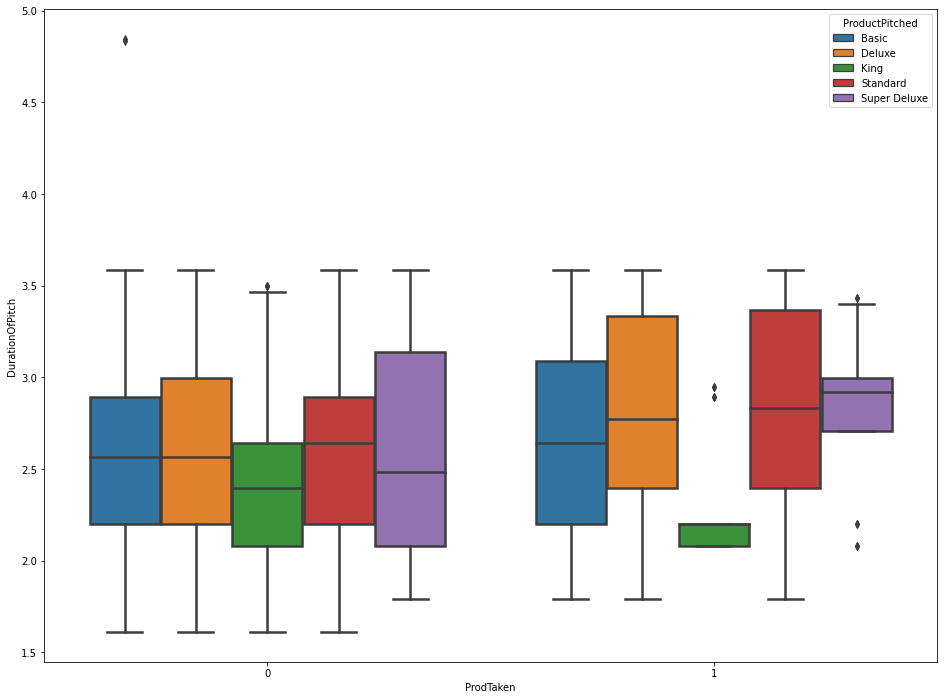

In [714]:
plt.figure(figsize=(16, 12))
sns.boxplot(df['ProdTaken'],df['DurationOfPitch'],hue=df['ProductPitched'], linewidth=2.5)
plt.show()

- As expected, it is easier to vicualize the difference in income by Product_Pitches with this boxplot. We so have this natural increase we spoke about but notice Standard customers have a somewhat higher average income than th Deluxe package, but apart from that mismatch, the other packages follow our logic. Notice much less outliers in the cohort that accepted the package and notice the distribution between packages for both groups is very similar. This may make it difficult for our models to discern between the two groups.
- On the second boxplot, we can notice the pitchlength for those who accepted the package is comparably higher, moreover, and as we noted from the groupby, King package mean pitchlenght is much lower than the other packages. Also notice the oulier in Basic package who didn't take it, poor agent! Spent hours talking to the client but couldn't close the deal.

In [715]:
# Let us see the relationship between product pitched and the other varibales. Please note this could also be done with visualizations but with numbers it is much easier to obtain actionable
# insight
for i in df.columns[df.dtypes == 'category']:
    print(df.groupby('ProductPitched')[i].value_counts(normalize=True))

ProductPitched  ProdTaken
Basic           0            0.700326
                1            0.299674
Deluxe          0            0.882217
                1            0.117783
King            0            0.913043
                1            0.086957
Standard        0            0.832884
                1            0.167116
Super Deluxe    0            0.941520
                1            0.058480
Name: ProdTaken, dtype: float64
ProductPitched  TypeofContact  
Basic           Self Enquiry       0.718341
                Company Invited    0.281659
Deluxe          Self Enquiry       0.684916
                Company Invited    0.315084
King            Self Enquiry       0.791304
                Company Invited    0.208696
Standard        Self Enquiry       0.706199
                Company Invited    0.293801
Super Deluxe    Self Enquiry       0.719298
                Company Invited    0.280702
Name: TypeofContact, dtype: float64
ProductPitched  CityTier
Basic           1           0

Customer Profiling
- Basic: Income is a percentage of a point lower than in other packages. however, this is the package that is most likely to be bought by customers. These are also the youngest cohort, with an average age of 31 years for those that accepted. Almost 80 per cent come from a big tier 1 city. Logically, this group also has the highest ratio of salaried employees vs small or large business owners. Cohort made up of Executives. The highest ratio of individuals iniated themselves the contact with the travel company as well.
- Standard: This package has a higher average income customer but is not the highest. They also tend to be somewhat older, at around 40 years old and are senior managers. They have an average of 1.2 children per visiting group and about 90 per cent of them are either salaried or own a small business. They have the largest proportion of clients preferring 5 start hotels.
- Deluxe: Surprisingly, this group's income is a percentage of point lower than the previous group, however this is possibly not statistically significant. This group's age stands between Basic and Standard package, at 37 years of age. It also has the highest percentage of custoemrs from tier 2 city. They seem to prefer 5 stars over 4 but most stick with 3. They are tough in sales pitch, giving 1 star most commonly after 3 stars. Finally, almost 30 per cent of this group's packages are compnay invited.
- Super Deluxe: This group has an even spread of male and female customers at exactly 50 precent each. They also have the highest percentage of divorced individuals in all of the groups! Perhaps that is the reasons they have, on average, less visitng children than the Basic package cusotmers. They also tend to have the longest calls with representataives, we can infere this means it is a difficult group to convince to buy the package. 
- King: Not surprisingly, this group made up of VP's has the highest average income of all groups. They also have the the oldest customers on average, with an age of 48 years old. Moreover, they have the highest average number of children visiting in the group, at 1.4. Almost three quarters of them own a car. Most of them gave a  5 start satisfaction rating to the sales pitch. Easier cusotmers than in lower packages, perhaps it is the age? The succesful pitches were also the shortest within this group. 64 per cent of customers in this segment are males.

# Outlier Detection,  Missing Value Treatment and Feature Engineering

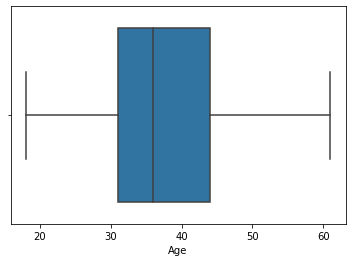

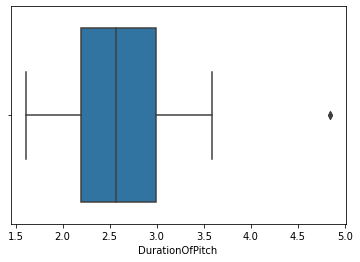

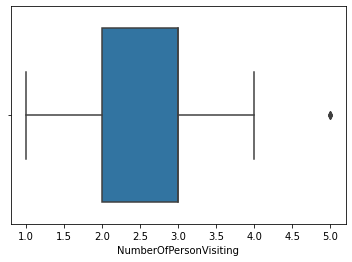

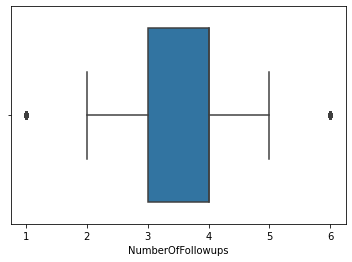

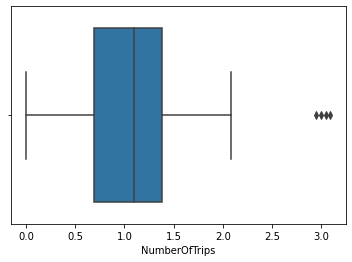

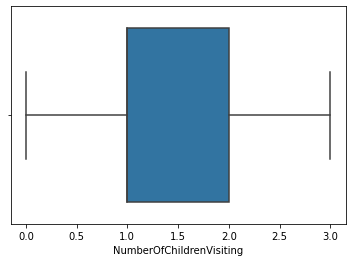

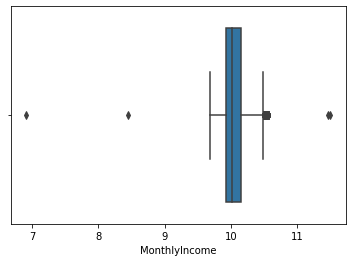

<Figure size 432x288 with 0 Axes>

In [670]:
for i in df.select_dtypes([np.number]).columns:
    sns.boxplot(df[i]);
    plt.figure()

We have a few outliers in our dataset in several of our columns. However, not all of them should be a concern. 
- In DurationOfPitch, we have an outlier at almost 2 hours long. For the sake of this exercise, we will assume this could have been a measuring error and get rid of that observation. 
- In NumberOfPersonsVisiting we see 5 marked as an outlier, however, 3 NumberOfChildrenVisiting is within acceptable range, and if we assume 2 parents + 3 children, then 5 should not be considered an outlier.
- Same reasoning with NumberOfFollowUps, it is safe to assume either 1 or 6 calls to close the deal are not improbable and this data is correct
- We do seem some outliers in NumberOfTrips, remember this is already the log of the actual number, as such, we will get rid of those observations
- Similarly in MonthlyIncome, we have a few observations with very low income and a couple observations with very high income, since there are just a few observations, we will get rid of these as well.

In [671]:
# Let us get rid of outliers in our dataset
df = df[(df['MonthlyIncome'] >= 8.5) & (df['MonthlyIncome'] <= 11)]
df = df[df['NumberOfTrips'] < 2.5]
df = df[df['DurationOfPitch'] < 4.5]

In [672]:
df.isna().sum()

ProdTaken                    0
Age                         95
TypeofContact                0
CityTier                     0
DurationOfPitch              0
Occupation                   0
Gender                       0
NumberOfPersonVisiting       0
NumberOfFollowups           45
ProductPitched               0
PreferredPropertyStar       25
MaritalStatus                0
NumberOfTrips                0
Passport                     0
PitchSatisfactionScore       0
OwnCar                       0
NumberOfChildrenVisiting    66
Designation                  0
MonthlyIncome                0
dtype: int64

In [673]:
# We notice there are 95 missing values in Age field, 45 in NumberOfFollowUps and 66 in NumberOfChildren. For NumberOfChildren and NumberOfFollowUps it is safe to assume NA as 0 
# children and no follow up in group, however, we cannot do that with age or PreferredPropertyStar. Nevertheless, thanks to our profiling, we know ages and preferences are quite different between 
# package groups,  we will impute these values that way!

df['Age'] = df['Age'].fillna(df.groupby('ProductPitched')['Age'].transform('mean')) #Fill Age NA with mean by group
df['Age'] = df['Age'].astype(int) # To get rid of decimals in imputation values
df['NumberOfFollowups'].replace(np.nan, 0, inplace=True) # Fill NA with 0 using replace method, same as below
df['NumberOfChildrenVisiting'].replace(np.nan, 0, inplace=True)
df['PreferredPropertyStar'].fillna(df['PreferredPropertyStar'].mode()[0], inplace=True)

########

In [674]:
# As we mentioned at the beginning, there are some categorical values which are ordinal in type. This means there is an implicit order within the levels (or categories) of the feature. While
# it is true we could feed our features as either categories or int, we will choose int because this allows our tree based algorithms to split more efficiently.
df['CityTier']= df['CityTier'].astype('int')
df['PitchSatisfactionScore']= df['PitchSatisfactionScore'].astype('int')
df['PreferredPropertyStar']= df['PreferredPropertyStar'].astype('int')

In [675]:
df['PreferredPropertyStar'].value_counts()

3    2678
5     846
4     827
Name: PreferredPropertyStar, dtype: int64

In [676]:
df.replace({'Basic': 0, 'Standard': 1, 'Deluxe': 2, 'Super Deluxe': 3, 'King': 4}, inplace=True)

In [677]:
# Get dummies for remaining nominal categorical values. Note that we could have used OrdinalEnocder for the columns with only 2 options since it would turn the levels into 0 or 1, but this way is
# more self-explanatory
df_dummies = pd.get_dummies(df, prefix=['TypeofContact', 'Occupation', 'Gender', 'MaritalStatus', 'Passport', 'OwnCar', 'Designation'],
                            columns=['TypeofContact', 'Occupation', 'Gender', 'MaritalStatus', 'Passport', 'OwnCar', 'Designation'], 
                            drop_first=True)

In [678]:
# For our feeature engineering we will consider MonthlyIncome per person as it is a better descriptor that total income. If we have two individuals earning 100k, but one of them has 4 group
# memebers and another one only 1, then the latter one is 'richer' per say. This can give extra information to our model
df_dummies['MonthlyIncomePerGroupMember'] = df_dummies['MonthlyIncome']/df_dummies['NumberOfPersonVisiting']
df_dummies.drop('MonthlyIncome', axis=1, inplace=True)

In [322]:
# It is usually not necessary to normalize when using tree-based models but it is still good practice to do so.
def z_transform(x):
    return (x - np.mean(x)) / np.std(x)

for i in ['Age', 'DurationOfPitch', 'NumberOfFollowups', 'NumberOfTrips', 'NumberOfChildrenVisiting', 'MonthlyIncomePerGroupMember']:
    df_dummies[i] = z_transform(df_dummies[i])

# Train and test set creation


In [323]:
# We have to separate our independent and dependent variable to create our sets, and add constant term to before we can perform VIF analysis
X = df_dummies.drop(columns='ProdTaken')
y = df_dummies[['ProdTaken']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=9, stratify=y)

In [324]:
# Let us see if our statified option worked
print(y_test.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))

ProdTaken
0            0.807044
1            0.192956
dtype: float64
ProdTaken
0            0.807553
1            0.192447
dtype: float64


Our sets seem to be properly balanced so we can continue with our project

# Correlation between variables
   - All 6 of our models will automtically perform feature selection when trained. Whether they drive the weight to zero because the feature is relatively unimportant, or whether they use a subsample of the full feature space, highly correlated independent varibales are usually not a problem. However, we will still perform VIF analysis to uncover any possible relationship between varibales. Instead of using VIF analysis to drop columns as in previous exercises, we use it here to learn more about our dataset!

In [491]:
X_VIF = X.copy()
X_VIF['Constant'] = 1

In [496]:
vif = pd.Series([variance_inflation_factor(X_VIF.values,i) for i in range(X_VIF.shape[1])],index=X_VIF.columns)
vif.sort_values(ascending=False)

Designation_VP                        inf
Designation_Senior Manager            inf
Designation_Manager                   inf
Designation_Executive                 inf
ProductPitched                        inf
Occupation_Salaried            548.761981
Occupation_Small Business      536.301119
Occupation_Large Business      184.530237
NumberOfPersonVisiting           8.266602
MonthlyIncomePerGroupMember      7.612793
MaritalStatus_Married            1.830831
MaritalStatus_Single             1.651266
MaritalStatus_Unmarried          1.591328
NumberOfChildrenVisiting         1.574313
Age                              1.383524
NumberOfFollowups                1.159510
CityTier                         1.128554
NumberOfTrips                    1.126840
DurationOfPitch                  1.024887
OwnCar_1                         1.019223
PitchSatisfactionScore           1.016715
Gender_Male                      1.013858
PreferredPropertyStar            1.010360
TypeofContact_Self Enquiry       1

- From the above VIF table, we can see we do have quite a few correlated columns. We notice that most of them have to do with occupation and position. This makes logical sense since knowing whether a person is salaried, has a small business or a large business will provide lots of information regarding the person's position. Moreover, knowing whether a person is a VP or not will also provide information about the next probable position, which is manager or executive.
- So why are we not getting rid of these columns? Firstly because the assumption that we shouldn't have any correlation between our columns is largely applied fro linear/logistic regression methods, or GLM's in general. However, since our models perform subsample in the columns, the probabilities that the highly correlated columns are chosen are low. Moreover, if we were to get rid of the above columns, we could be losing important information our models could find useful.

In [383]:
# We create a custom function to measure the performance of our models. Since we will also be applying several different models, this way we don't have to write a function every single time we
# require it

def metrics_func(model, X_train, X_test, y_train, y_test): # The function takes the model and then computes the performance 
    # measures on both train and test sets
    
    pred_train = model.predict(X_train) # makes predictions which we then pass to our performance measure functions
    pred_test = model.predict(X_test)
    
    # We use sci-kit pre made functions to print our results
    print("Accuracy on training set : ",accuracy_score(pred_train,y_train))
    print("Accuracy on test set : ",accuracy_score(pred_test,y_test))
    print("Recall on training set : ",recall_score(y_train,pred_train))
    print("Recall on test set : ",recall_score(y_test,pred_test))
    print("Precision on training set : ",precision_score(y_train,pred_train))
    print("Precision on test set : ",precision_score(y_test,pred_test))
    print("F1 score on training set : ",f1_score(y_train,pred_train))
    print("F1 score on test set : ",f1_score(y_test,pred_test))

# We also need a function that creates a confusion matrix so we can visualize the performance of our model and compare the
# vanilla version with the improved versions, as well as comparing algorithm perfomances (logistic regression - tree)
def conf_matrix(model, X, y, labels=[1, 0]):
    
    y_predict = model.predict(X)
    cm=metrics.confusion_matrix( y, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]], # show labels
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in # format how many zeroes to show
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in # show underneath count the percentage value
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)] # zip function to make tuples of number of values and respective %
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# We need a function that will output a DataFrame comparing the models we provide to it
def comp_func(model):

    
    pred_train = model.predict(X_train) # makes predictions which we then pass to our performance measure functions
    pred_test = model.predict(X_test)
    
    score_list=[] 
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    
    train_f1 = f1_score(y_train,pred_train)
    test_f1 = f1_score(y_test,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision, train_f1, test_f1))
    
    return score_list

# Decision Tree

# A word on metric of choice
- A word on performance metric of choice. We have two main metrics to choose from. That is precision and recall. With precision we are trying to minimize the number of false positives. In our case, that means minimizing the number of people our model expects to accept the package but that in reality, they don't. On the other hand, with recall we want to minimize the number of False Negatives, in other words, the examples that are categorized as not accepting the package but in reality they do. From a business point of view and basing our decision on the fact that the marketing team spends a considerable amount of money in calling customers (Remember we have calls of 30 minutes plus follow-up calls), then it is imperative that the people we call are the most probable to accept the travel package. However, that is not the totality of the story. We know that only about 20 per cent or so of all individuals end up accepting the package. If we were to only focus on the ones that would highly probably accept the package, that 20 per cent would be dimished even more so, and that is an implicit cost for the company. For the reasons outlined above, we will use F1 score as our peformance metric, which takes into consideration the miximization of both precision (cost of targeting non takers), and recall (cost of not targeting possiblr clients). In economics, recall measures what we call our opportunity cost.
- A word on model improvement. Right out of the box, most of our algorithms will not perform as best as they could (exception being XGBoost since it is already a very robust and efficient implementation of Gradient Boosting). The most time efficient way to improve our bagging and boosting algorithm is through cross validation grid search. It helps us construct models with different values in each of the models' hyperparameters. However, all of our algorithms (except decision tree), work by ensemble learning, that is, they use many weak models to create a more robust and better peforming model. Since this means training thousands of estimators, the grid search would take from 30 minutes to even hours. For this reason, on order to improve model performance, we has decided to use Random Cross Validation Grid Search with 20 iterations. It is more efficient than regular GridSearch and most of the time, ahcieves the same or very close performance but takes a fraction of the time to implement. 

In [176]:
dt = DecisionTreeClassifier(random_state=5) # we first implement the tree without any hyperparameter tuning
dt.fit(X_train, y_train)
dt.score(X_train, y_train)

1.0

Accuracy on training set :  1.0
Accuracy on test set :  0.9096477794793262
Recall on training set :  1.0
Recall on test set :  0.7817460317460317
Precision on training set :  1.0
Precision on test set :  0.7576923076923077
F1 score on training set :  1.0
F1 score on test set :  0.7695312500000001
None
None


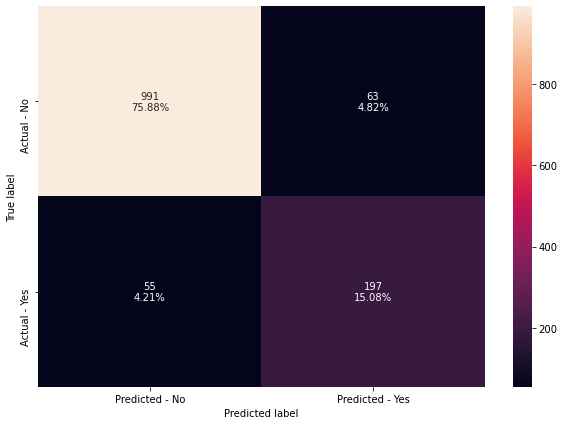

In [327]:
# As is common with non-regularized trees, we get an amazing accuracy of 1, but let us see how we do in other performance metrics!
#Calculating different metrics
print(metrics_func(dt, X_train, X_test, y_train, y_test))

# Creating confusion matrix
print(conf_matrix(dt, X_test, y_test))

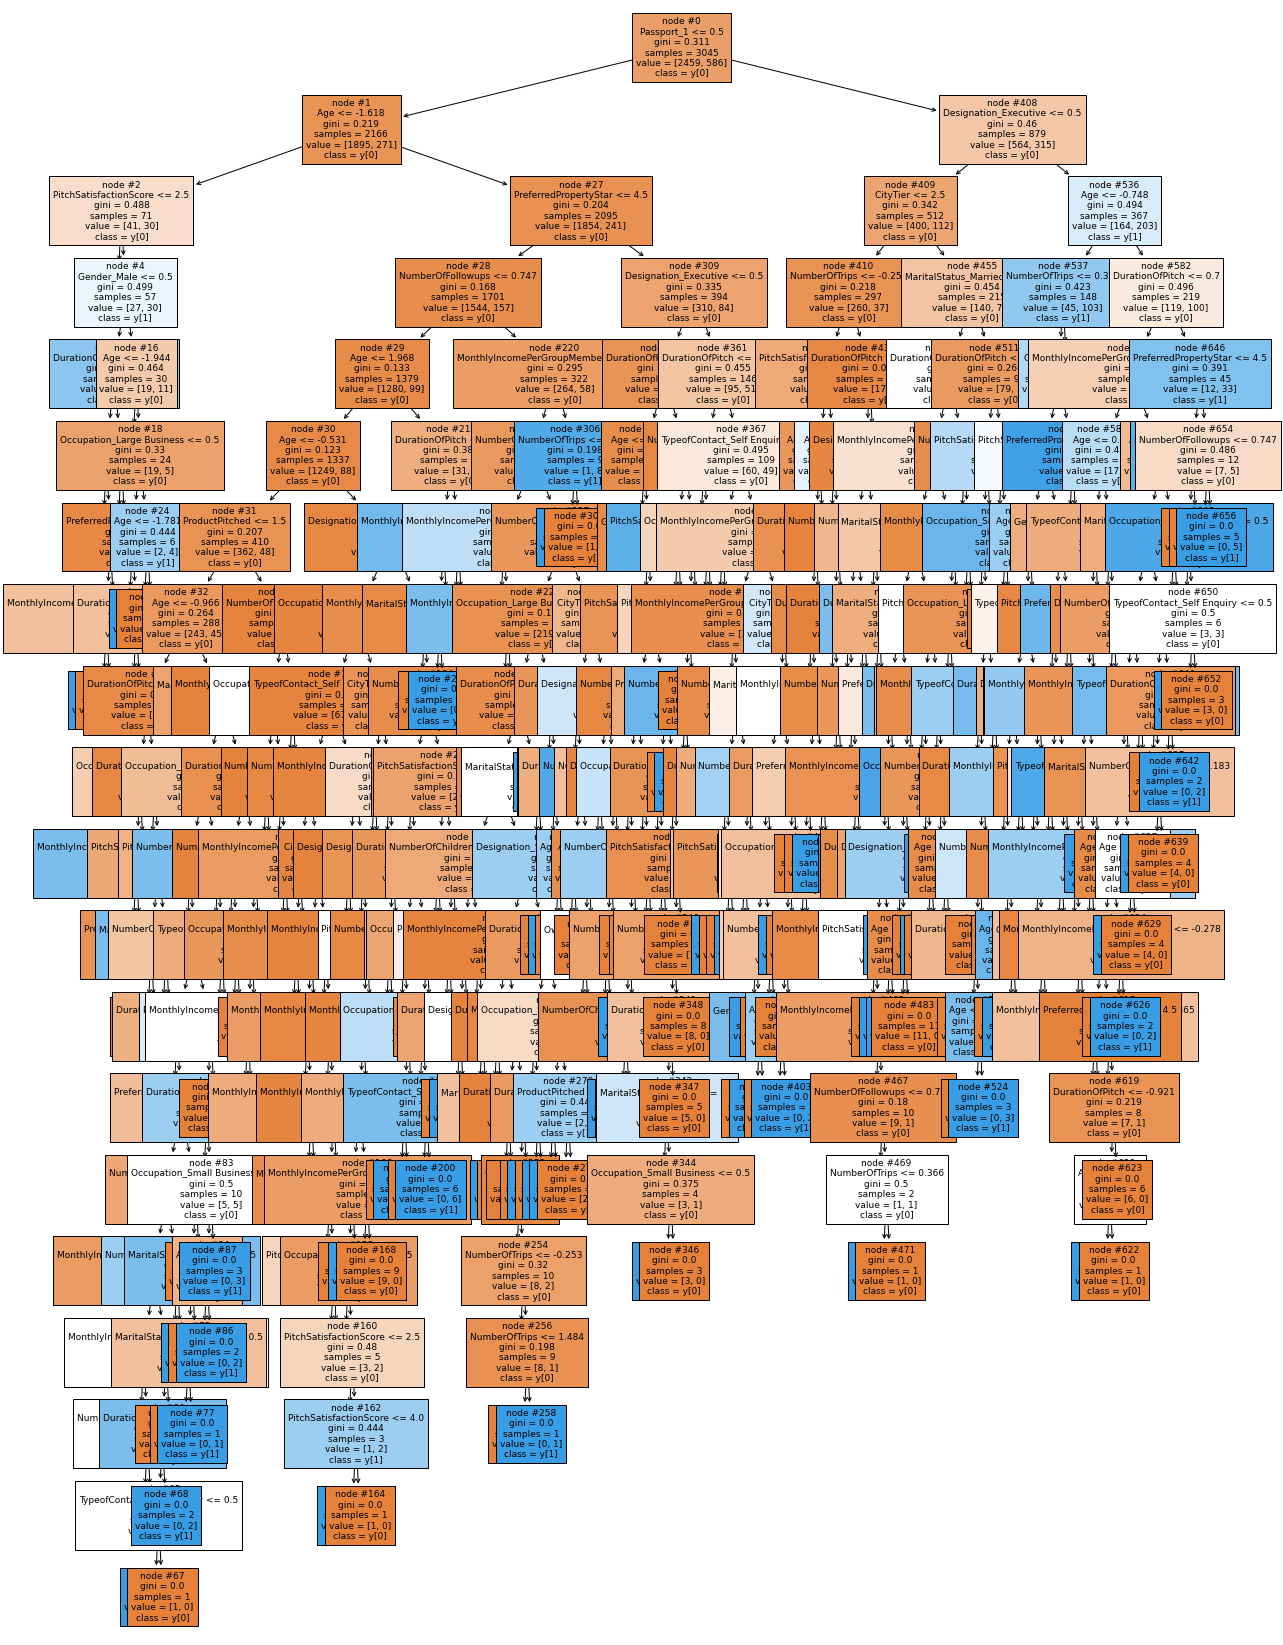

In [178]:
plt.figure(figsize=(20,30))
tree.plot_tree(dt,feature_names=list(X.columns),filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

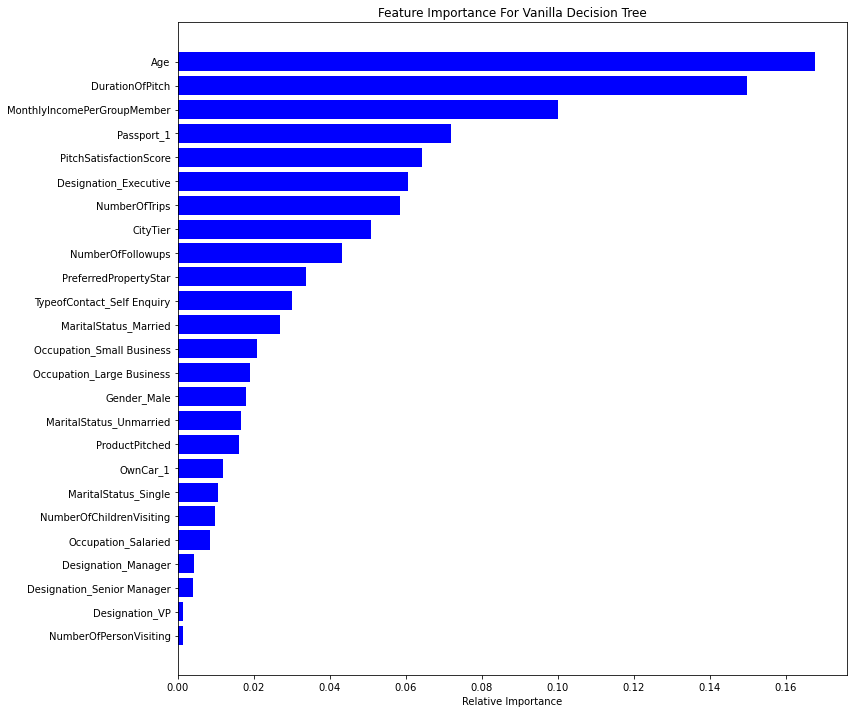

In [723]:
features = X_train.columns
indices = np.argsort(dt.feature_importances_)

plt.figure(figsize=(12,12))
plt.title('Feature Importance For Vanilla Decision Tree')
plt.barh(range(25), dt.feature_importances_[indices], color='blue')
plt.yticks(range(25), [features[i] for i in indices]) # plots the names of the features on the y axis
plt.xlabel('Relative Importance')
plt.show()

- There are some clear problems with our model here. Firstly, the decision tree overfits the data as they to do when left to grow until all examples are correctly categorized. We see an amazing accuracy of 1 vs 91 per cent in our testing set. Next, our precision is not great at 76 per cent, and finally, the complexity of our tree is outrageous. Our recall is similar to our our precision, 78 in testing set. Our metric of choice is acceptable, we have F1 score of 77 in testing set, although again, we see evidence of overfitting since training F1 is 1.0. We will proceed to do some pre-pruning and changing the relative weights of our response variable.
- We can see Age and DurationOfPitch are highly important features for our model, this corroborates our findings from EDA where we noted a difference in the distribution of descriptive statistics between the group that took the package and those who didn't. Likewise, passport has a relative importance of 8 per cent and SatisfactionScore treads a tiny bit behind and 6.5 per cent. From there, we see feature importance decrease at a steady pace, from Designation_Executive all the way to NumberofPersonVisiting, with almost 1 percent or less importance. It will be interesting to see how our tuned decision tree compares.

# Decision Tree - Improvement

In [179]:
dt_tuned = DecisionTreeClassifier(random_state=10)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2,10), # Max depth of tree
              'min_samples_leaf': np.arange(1,10), # the minimum number of samples a leaf has to have for it to split
              'max_leaf_nodes' : np.arange(0,10), # maximum number of leaf nodes (terminal nodes)
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1] # min impurity required for a split
             }

# Here we want to maximize precision so we choose the appropriate score metric
scorer = metrics.make_scorer(metrics.f1_score)


grid_search = GridSearchCV(dt_tuned, parameters, scoring=scorer,n_jobs=-1) # We use regular GridSearch since this is not en ensemble model
grid_search = grid_search.fit(X_train, y_train)

# Set the tree to the best combination of parameters
dt_tuned = grid_search.best_estimator_
dt_tuned.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=7,
                       min_impurity_decrease=0.0001, random_state=10)

Accuracy on training set :  0.8266009852216749
Accuracy on test set :  0.833843797856049
Recall on training set :  0.1757679180887372
Recall on test set :  0.20634920634920634
Precision on training set :  0.6959459459459459
Precision on test set :  0.7536231884057971
F1 score on training set :  0.2806539509536785
F1 score on test set :  0.32398753894081


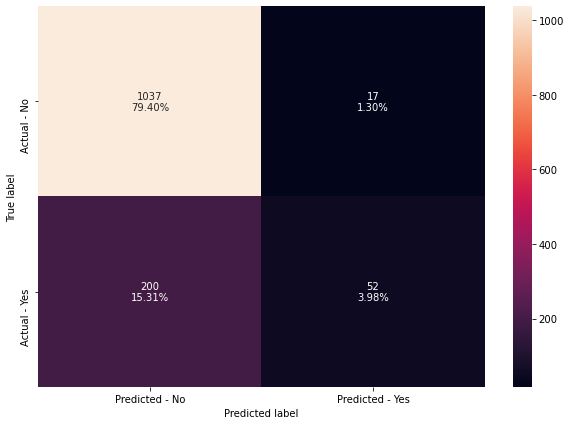

In [388]:
metrics_func(dt_tuned, X_train, X_test, y_train, y_test)

conf_matrix(dt_tuned, X_test, y_test)

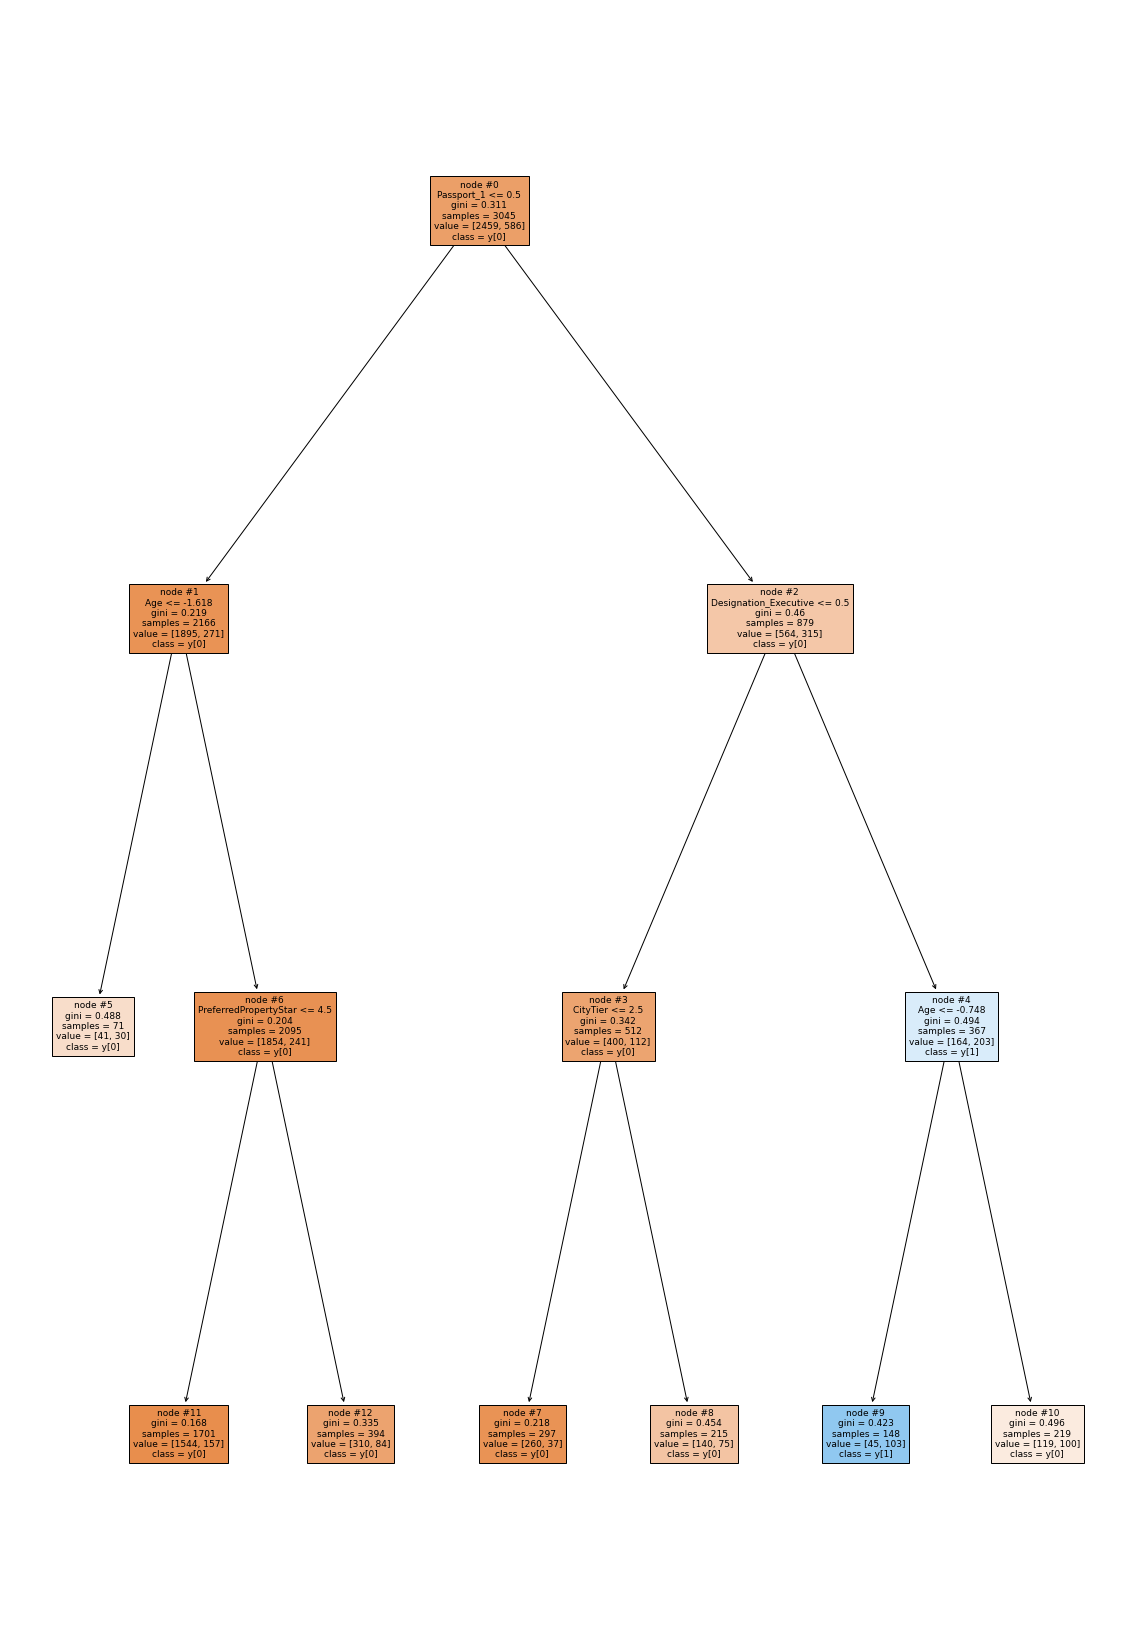

In [389]:
plt.figure(figsize=(20,30))
tree.plot_tree(dt_tuned,feature_names=list(X.columns),filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [390]:
pd.DataFrame(dt_tuned.feature_importances_, columns = ["Imp"], 
                    index = X_train.columns).sort_values(by = 'Imp', ascending = False).T

,Passport_1,Designation_Executive,Age,CityTier,PreferredPropertyStar,Gender_Male,Designation_VP,Designation_Senior Manager,Designation_Manager,OwnCar_1,MaritalStatus_Unmarried,MaritalStatus_Single,MaritalStatus_Married,Occupation_Salaried,Occupation_Small Business,Occupation_Large Business,TypeofContact_Self Enquiry,NumberOfChildrenVisiting,PitchSatisfactionScore,NumberOfTrips,ProductPitched,NumberOfFollowups,NumberOfPersonVisiting,DurationOfPitch,MonthlyIncomePerGroupMember
Imp,0.422993,0.297222,0.143646,0.077995,0.058144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [391]:
models = [dt, dt_tuned]
met = []
for i in models:
    met.append(comp_func(i))
pd.DataFrame.from_records(met, columns=['Acc_Train', 'Acc_Test', 'Recall_Train', 'Recall_Test', 'Prec_Train', 'Prec_Test', 'F1_Train', 'F1_Test'], index = ['dt', 'dt_tuned'])

,Acc_Train,Acc_Test,Recall_Train,Recall_Test,Prec_Train,Prec_Test,F1_Train,F1_Test
dt,1.000000,0.909648,1.000000,0.781746,1.000000,0.757692,1.000000,0.769531
dt_tuned,0.826601,0.833844,0.175768,0.206349,0.695946,0.753623,0.280654,0.323988


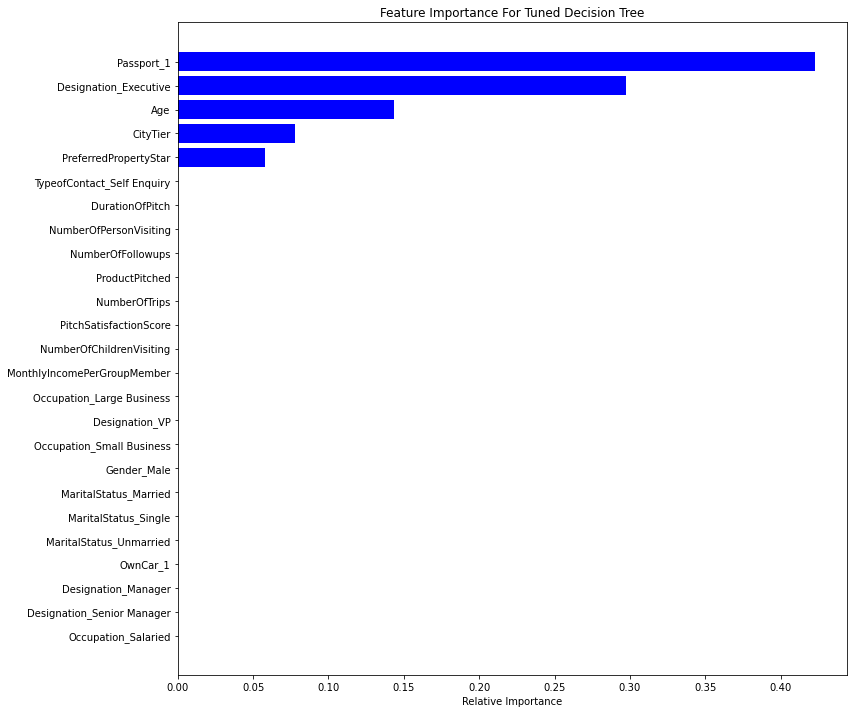

In [721]:
features = X_train.columns
indices = np.argsort(dt_tuned.feature_importances_)

plt.figure(figsize=(12,12))
plt.title('Feature Importance For Tuned Decision Tree')
plt.barh(range(25), dt_tuned.feature_importances_[indices], color='blue')
plt.yticks(range(25), [features[i] for i in indices]) # plots the names of the features on the y axis
plt.xlabel('Relative Importance')
plt.show()

    Improvement Discussion

We have 1 good news and 2 bad news after trying to improve the performance of our model. First, we were able to stop our model from overfitting the data, which in turn also made our final model much simpler thatn the non-regularized model, our DataFrame above makes comparison easy. Notice accuracy is almost the same in testing and training set, 83 per cent in both cases. We were able to keep precison at around 75 per cent like in our first model (on testing set), moreover, we did suffer a loss in Recall to a level of .21 or so, and training set was even worse at 18 per cent.There are quite a bit of False Negatives in our predicted responses, however, they would not mean a direct loss to the business as opposed to the effect of having False Positives. Our metric of choice suffered immensely because of the loss in Recall, from 77 pre cent to 32 percent. In other words, our tuned Decision tree does badly, but at least it'll do badly in general, so we know what to expect. Since the vanilla implementation of the tree overfits, that models could either do very well, or very badly in real life scenarios.

We can see, as we predicted at the beginning of our EDA, that whether a person has a passport or not makes a large difference in how they are predicted to react. Likewise, that difference we noticed in mean age is shown to have a large importance in our model. This, again, comes to show how critical it is for  Data Analyst to perform EDA and discover the relationships between variables. Let us now see if it is the same for our random forest! Of course, compared to our first tree which overfits the data, here we only have 4 features being used, which means the relative importance is much higher than in the first model.

# Additonal technique - Post Pruning

In [567]:
# In post-pruning, we first fully grow a tree and then proceed to delete nodes, checking for diminish performance each time we do so. CPP-Alpha is the meeasure we use, with an alpha of zero 
# signifying a fully grown tree and max(alpha) signifying only the root of our tree. It follows that every time we delete a node, our leaf purity decreases, since there are less splits and thus
# data becomes more heterogenous. ALterntively, we can say the gini coefficient increases as we prune our tree. Let us see these values for our specific tree.

path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities


In [568]:
pd.DataFrame(path).rename(columns={'ccp_alphas': "CCP_Alpha", 'impurities': 'Impurities'})# Because of the complexity of our 
# initial tree, we can see there are many prune possibilities. Let us now graph this results in a line-plot to see how impurities increase as alpha increases

,CCP_Alpha,Impurities
0,0.000000,0.000000
1,0.000215,0.000645
2,0.000217,0.001297
3,0.000246,0.001789
4,0.000274,0.002337
...,...,...
156,0.003930,0.264395
157,0.004120,0.268515
158,0.004265,0.272780
159,0.015699,0.288479


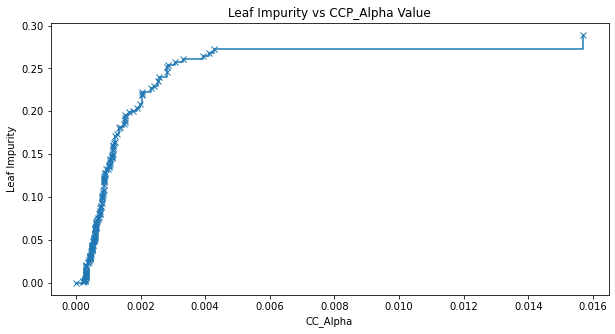

In [574]:
# The following graph makes it easier to visuzalize the impurity increase
fig, ax = plt.subplots(figsize=(10,5)) # graph size
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='x', drawstyle="steps-post") # We don't require the last observation since we know its the root node so we avoid graphing that
ax.set_xlabel("CC_Alpha")
ax.set_ylabel("Leaf Impurity")
ax.set_title("Leaf Impurity vs CCP_Alpha Value")
plt.show()

In [585]:
# The following code creates a list with all th possible values of ccp_alpha in our above dataframe. We remove the last value because that is only our root node.

ccp_alphas = ccp_alphas[0:160] # Remember the number to the right is non-inclusive
trees_ccp = []

for i in ccp_alphas:
    dt_alphalist = DecisionTreeClassifier(random_state=25, ccp_alpha=i)
    dt_alphalist.fit(X_train, y_train)
    trees_ccp.append(dt_alphalist)

In [586]:
f1_tr=[] # Get all the different f1 scores for each of the alphas in training data
for i in trees_ccp:
    pred=i.predict(X_train)
    values_train=metrics.f1_score(y_train,pred)
    f1_tr.append(values_train)
    
f1_te=[] # Get all the different f1 scores for each of the alphas in testing data
for i in trees_ccp:
    pred=i.predict(X_test)
    values_test=metrics.f1_score(y_test,pred)
    f1_te.append(values_test)

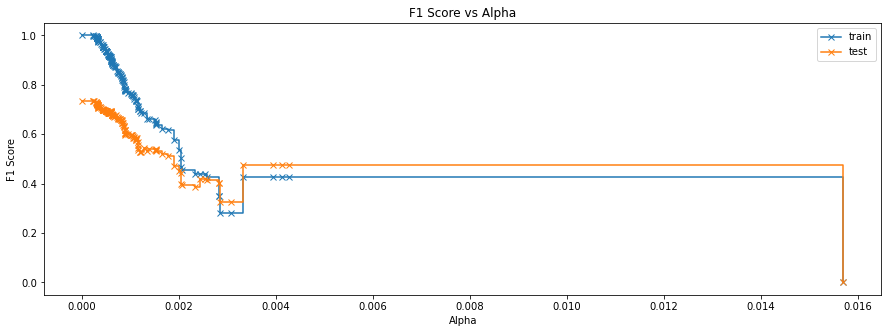

In [587]:
# Plot the f1 cruves for both testing and training set for each of the values of alpha, except the last one.
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel("Alpha")
ax.set_ylabel("F1 Score")
ax.set_title("F1 Score vs Alpha")
ax.plot(ccp_alphas, f1_tr, marker='x', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, f1_te, marker='x', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [598]:
pd.DataFrame(f1_te).head()

,0
0,0.733333
1,0.733333
2,0.733333
3,0.733333
4,0.730845


In [599]:
best_model_highest_alpha = clfs[3] # Note from our dataframe above that the first 4 trees have the same f1 score, we would take the 4th tree as the best since it would also be the simplest of
# three, the one with largest alpha.
best_model_highest_alpha

DecisionTreeClassifier(ccp_alpha=0.0002463054187192118, random_state=1)

In [600]:
models = [dt, dt_tuned, best_model_highest_alpha]
met = []
for i in models:
    met.append(comp_func(i))
pd.DataFrame.from_records(met, columns=['Acc_Train', 'Acc_Test', 'Recall_Train', 'Recall_Test', 'Prec_Train', 'Prec_Test', 'F1_Train', 'F1_Test'], 
                          index = ['dt', 'dt_tuned', 'best_model_highest_alpha'])

,Acc_Train,Acc_Test,Recall_Train,Recall_Test,Prec_Train,Prec_Test,F1_Train,F1_Test
dt,1.000000,0.909648,1.000000,0.781746,1.000000,0.757692,1.000000,0.769531
dt_tuned,0.826601,0.833844,0.175768,0.206349,0.695946,0.753623,0.280654,0.323988
best_model_highest_alpha,0.999343,0.897397,0.996587,0.734127,1.000000,0.734127,0.998291,0.734127


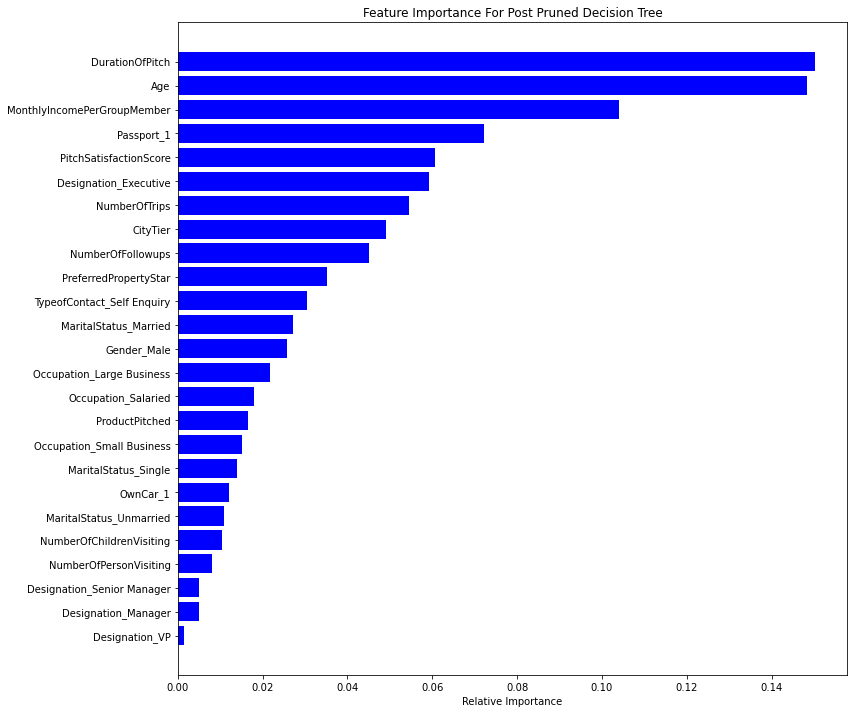

In [725]:
features = X_train.columns
indices = np.argsort(best_model_highest_alpha.feature_importances_)

plt.figure(figsize=(12,12))
plt.title('Feature Importance For Post Pruned Decision Tree')
plt.barh(range(25), best_model_highest_alpha.feature_importances_[indices], color='blue')
plt.yticks(range(25), [features[i] for i in indices]) # plots the names of the features on the y axis
plt.xlabel('Relative Importance')
plt.show()

Obviously, since our best post-pruned tree is very close to alpha of zero, it will tend to overfit as our vanilla implementation. For this reason, both models actually performed very similarly. Not surpisingly, feature importance is the same as in our first tree and the same observations apply.

# Random Forest

Accuracy on training set :  1.0
Accuracy on test set :  0.9111791730474732
Recall on training set :  1.0
Recall on test set :  0.5793650793650794
Precision on training set :  1.0
Precision on test set :  0.9358974358974359
F1 score on training set :  1.0
F1 score on test set :  0.715686274509804


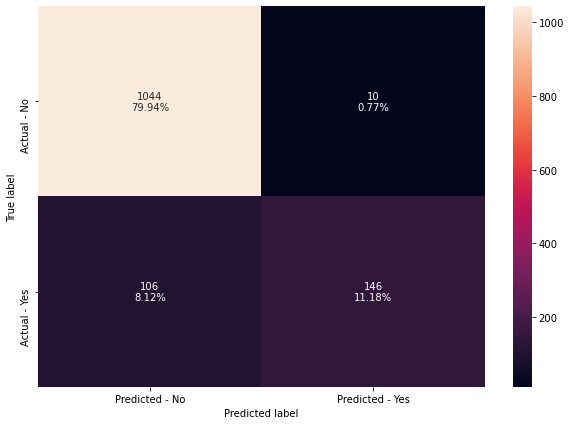

In [393]:
# We will now implement a vanilla random forest and then proceed to do some hyperparameter tuning as we did with our decision tree
# Initiate model
rf = RandomForestClassifier(random_state= 15)
rf.fit(X_train,y_train)

metrics_func(rf, X_train, X_test, y_train, y_test) # Use our predefined function to get important scores and show confusion matrix
conf_matrix(rf, X_test, y_test)

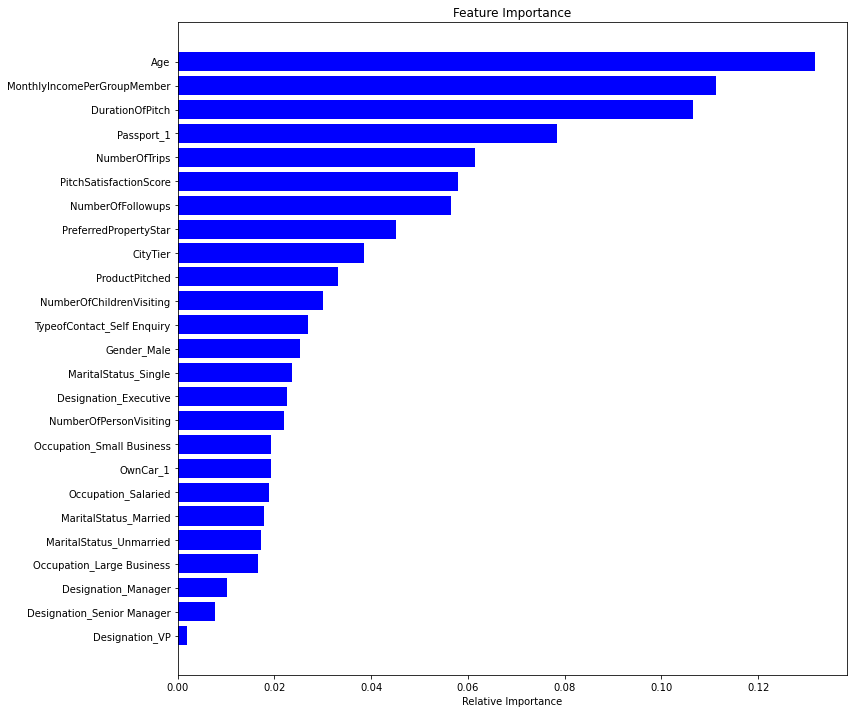

In [728]:
features = X_train.columns
indices = np.argsort(rf.feature_importances_)

plt.figure(figsize=(12,12))
plt.title('Feature Importance')
plt.barh(range(25), rf.feature_importances_[indices], color='blue')
plt.yticks(range(25), [features[i] for i in indices]) # plots the names of the features on the y axis
plt.xlabel('Relative Importance')
plt.show()

- Right out of the bag (pun intended), our random forest performs better than our single decision tree (in precision metric) at 94 per cent, however, this is to be expected. Having a bunch of weak learners, even if they get predictions wrong, together will perform better than only a single of them. However, we are still getting overfitting as we can tell from the Recall results in our testing set, training recall is great at 1.0 but of course it doesn't generalize well, with testing recall at 58 percent . Precision is also much, much imporved over the decision tree we first implemented but still overfitting.Training precison is at 1.0 again but we suffer an 8 per cent loss when using unseen data in our model, with 94 per cent precision when testing. Our F1 score is not too bad, suffering a 28 per cent loss when comparing testing to training result, or 72 vs 100 per cent. Let's see if we can improve this model.
- At first sight, looking at our RF feature importances and noting they are almost the same as our untuned Decison Tree should come at no surprise. Firstly, because by default, Random Forests in sci-kit learn use fully grown DT as estimators, and secondly because the number of features is set to sqrt(n_features)and this allows for all features to be used once all trees are grown (well, a very high probability at least). Our three most important features, Age, MonthlyIncomeperGroupMember and DurationOfPitch are the exact same, however, in DT the most important feature is Age, followed by Duration of Pitch, but with the Random Forest we see Age as being the most important feature. The tail of the bar chart is also almost the same, with DesignationVP at the end, followed by other Designations and the MaritalStatus of the individual.

# Random Forest - Improvement

In [396]:
# Let us now tune the hyperparamters of our Random Forest. Note that there only a couple of extra hp to tuned compared to our Decision Tree. First, we have number of estimators, which stands
# for how many trees will be used in our RF. Then we have max_features, which selects the number of columns each Decision Tree has to choose from when splitting. The other hp are the same as the 
# last model

rf_t = RandomForestClassifier(class_weight='balanced',random_state= 10,oob_score=False, bootstrap=True) # We set oob_score false as we will use our own function to check
# for performance. Bootstrap true as to allow sampling with replacement. Weights are set to 'balanced' which will automatically set the weights required to balance the dataset.
parameters = {  
                'max_depth': np.arange(5,30,1),
                'max_features': ['sqrt','log2', 20, None], # This is an extra hyperparameter not present in Decision Tree and sets the sample space for features
                'min_samples_leaf': np.arange(1,15,1),
                'min_samples_split': np.arange(2, 20, 1),
                'n_estimators': np.arange(50,100,5)} # Again, extra hp that controls how many trees to use in our RF


# Scoring function. F1 actually does better than maximizing precision, so we chose that performance measure.
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_rf = RandomizedSearchCV(rf_t, parameters, scoring=scorer, cv=5, n_jobs=-1, n_iter=20) # Note that setting n_jobs to -1 allows for parallel processing. We used RandomizedSearch to save time
grid_rf = grid_rf.fit(X_train, y_train)

rf_t = grid_rf.best_estimator_
# Fit the best algorithm to the data. 
rf_t.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=20,
                       min_samples_leaf=2, min_samples_split=3, n_estimators=85,
                       random_state=10)

Accuracy on training set :  0.9990147783251232
Accuracy on test set :  0.9257274119448698
Recall on training set :  1.0
Recall on test set :  0.7182539682539683
Precision on training set :  0.9949066213921901
Precision on test set :  0.8743961352657005
F1 score on training set :  0.9974468085106384
F1 score on test set :  0.7886710239651415


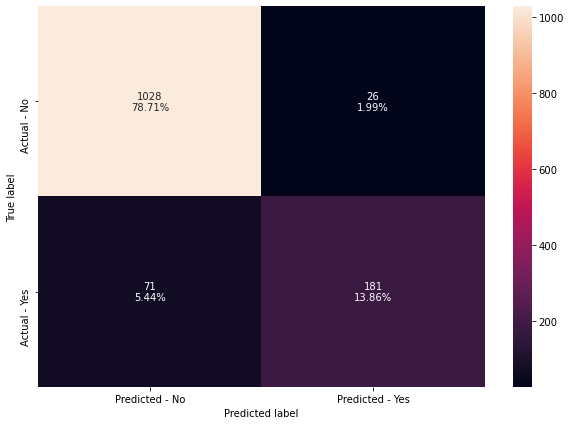

In [398]:
metrics_func(rf_t, X_train, X_test, y_train, y_test)

conf_matrix(rf_t, X_test, y_test)

In [412]:
models = [rf, rf_t]
met = []
for i in models:
    met.append(comp_func(i))
pd.DataFrame.from_records(met, columns=['Acc_Train', 'Acc_Test', 'Recall_Train', 'Recall_Test', 'Prec_Train', 'Prec_Test', 'F1_Train', 'F1_Test'], index = ['rf', 'rf_t'])

,Acc_Train,Acc_Test,Recall_Train,Recall_Test,Prec_Train,Prec_Test,F1_Train,F1_Test
rf,1.000000,0.911179,1.0,0.579365,1.000000,0.935897,1.000000,0.715686
rf_t,0.999015,0.925727,1.0,0.718254,0.994907,0.874396,0.997447,0.788671


    Improvement Discussion

The grid search has not been completely succesful but we can see tangible improvement. We were able to somewhat reduce overfitting, as Accuracy on training set is not fully 1, but accuracy on test set decreases to 93 per cent. Likewise, precision on testing set stayed at an acceptable level of 87, but we were able to increase Recall to 72 per cent, which compared to 58 on the un-tuned RF, presents important improvement! After comparing RF with a single Decision Tree, it is clear the RF is superior in every peformance measure. However, it did take some time to run the GridSearch, which is why we opted for RandomizedGS instead of running 5000 different models. Our F1 metric in testing set is quite promising, we see a 10 per cent increase in performance there, likely due to the gain in Recall from our GridSearch. We now have an 79 per cent F1 score, but even more importantly, we compound that score with a Precision of 87 per cent, which means we are not targeting too many clients who wont take the package, but thanks to a Recall of 72 per cent, we are not losing too mnay probable clients either!

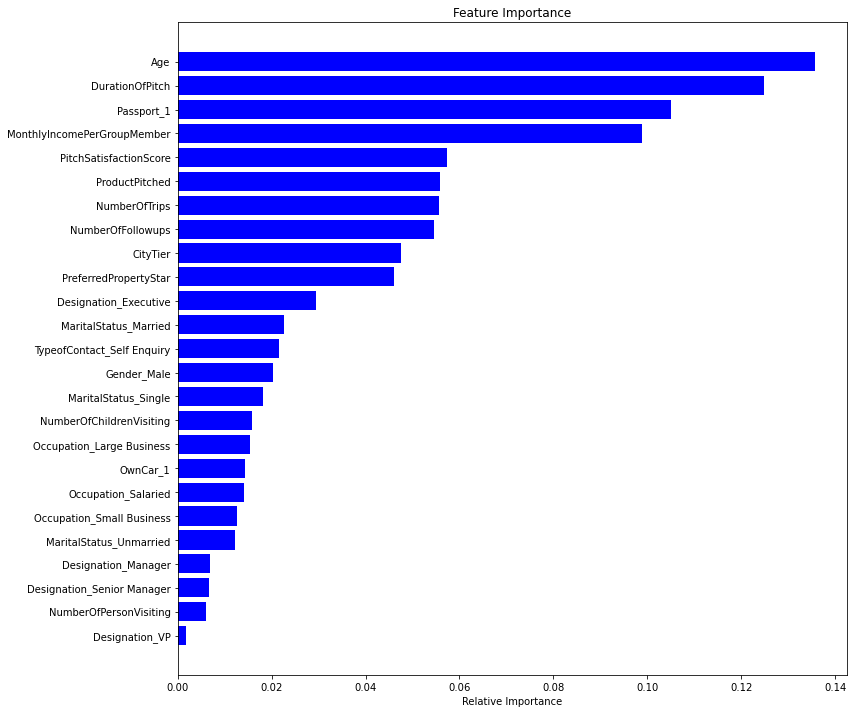

In [400]:
# Let us now see the importance our Random Forest gives to the features at hand. This information will help us when providing actionable insight.
features = X_train.columns
indices = np.argsort(grid_rf.best_estimator_.feature_importances_)

plt.figure(figsize=(12,12))
plt.title('Feature Importance')
plt.barh(range(25), grid_rf.best_estimator_.feature_importances_[indices], color='blue')
plt.yticks(range(25), [features[i] for i in indices]) # plots the names of the features on the y axis
plt.xlabel('Relative Importance')
plt.show()

Some difference but similar importance to our dt. Remember our Decision Tree only had 4 levels so that's why we got only a few features when we looked at their importance. However, as we said in the EDA, Age and passport are quite useful to predict whether a person will take the package or not. Of course, by transitive property, if our tuned Random Forest is similar to vanilla DT model, then it will also be similar to our vanilla RF. And that is indeed the case. However while 2 of our most important features are the same, Age and DurationofPitch, Passport has overcome MonthlyIncomePerGroup member to become third most important. Likewise, our least important feature is, again, DesignationVp followed by Other designation and MaritalStatus, and whether the individual own a car or not.

# Bagging Classifier

In [405]:
# We will now try to implement a Bagging Classifier. The main difference between the Random Forest an this next technique, is that by default trees are left to fully grow and the totality of the
# columns are used when splitting the decision trees. However, as we noted above, our top performing RF made used all avialable feautures anyway. Since our results using a tree estimator
# would be very similar to a RF, we opt to use LogisticRegression as estimator instead!

bagging = BaggingClassifier(base_estimator=LogisticRegression(), random_state = 5)
bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=LogisticRegression(), random_state=5)

In [406]:
metrics_func(bagging, X_train, X_test, y_train, y_test)

Accuracy on training set :  0.8367816091954023
Accuracy on test set :  0.835375191424196
Recall on training set :  0.31399317406143346
Recall on test set :  0.31746031746031744
Precision on training set :  0.6594982078853047
Precision on test set :  0.6504065040650406
F1 score on training set :  0.4254335260115607
F1 score on test set :  0.42666666666666664


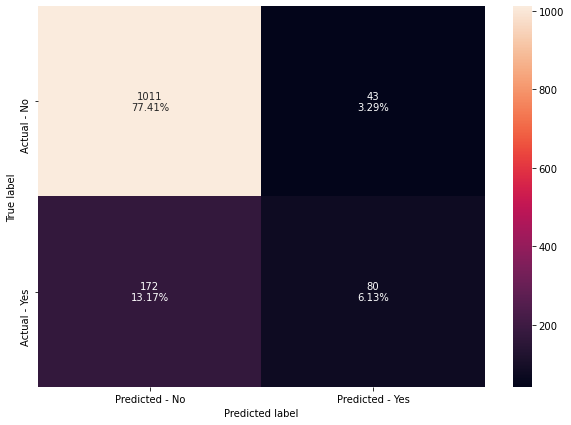

In [407]:
conf_matrix(bagging, X_test, y_test)

We have found a model that doesn't overfit training data! This is because of the type of estimator we used, of course. I believe we have started to see a trend with our models, they struggle with the number of False Negatives they produce. All three classifiers thus far have had this issue, let us now see how a tuned bagging classifier will do! Most importantly though, this model is too close the our 81 threshold of just predicting the most common class and getting an accuracy of 81, this is concerning! Morever, we have terrible recall, at 32 per cent on testing set. Precison is not terrible, hovering arounf 65 per cent for both cases, however, because of the low recall, our metric of choice, F1, is not great, at 43 per cent in both cases. We will now tune the hyperparamters but also change the threshold value and see how we do.

# Bagging - Improvement

In [413]:
# Let us now tune the hyperparamters of our bagging algorithm. We are able to choose the percentage of bootstrap samples to use as well as the feature subspace. 
from sklearn.linear_model import LogisticRegression

bagging_t = BaggingClassifier(base_estimator=LogisticRegression( class_weight='balanced', penalty = 'none', solver='saga'), random_state= 5, bootstrap=True) # Bootstrap true as to allow 
# sampling with replacement. Weights are set to 'balanced' which will automatically set the weights required to balance the dataset.
parameters = {  
               'max_samples': [.8,.9, 1.0, 1.5, 2.0], # When using bootstrap, allows us to select the percentage of samples used to train each model
               'max_features': [.8,.9, 1.0, 1.5, 2.0], # This is an extra hyperparameter not present in Decision Tree and sets the sample space for features
               'bootstrap_features': [True, False],
               'n_estimators': np.arange(20, 50, 10)}
# Scoring function. F1 actually does better than maximizing precision, so we chose that performance measure.
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_bagging = RandomizedSearchCV(bagging_t, parameters, scoring=scorer, cv=5, n_jobs=-1, n_iter=20) # Note that setting n_jobs to -1 allows for parallel processing. 
                                                                                                     #We used RandomizedSearch to save time
grid_bagging = grid_bagging.fit(X_train, y_train)

bagging_t = grid_bagging.best_estimator_

# Fit the best algorithm to the data. 
bagging_t.fit(X_train, y_train)


BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced',
                                                    penalty='none',
                                                    solver='saga'),
                  max_features=0.9, max_samples=0.8, n_estimators=20,
                  random_state=5)

Accuracy on training set :  0.7513957307060756
Accuracy on test set :  0.7480857580398163
Recall on training set :  0.7559726962457338
Recall on test set :  0.7182539682539683
Precision on training set :  0.41911069063386946
Precision on test set :  0.4123006833712984
F1 score on training set :  0.5392574558734023
F1 score on test set :  0.5238784370477568


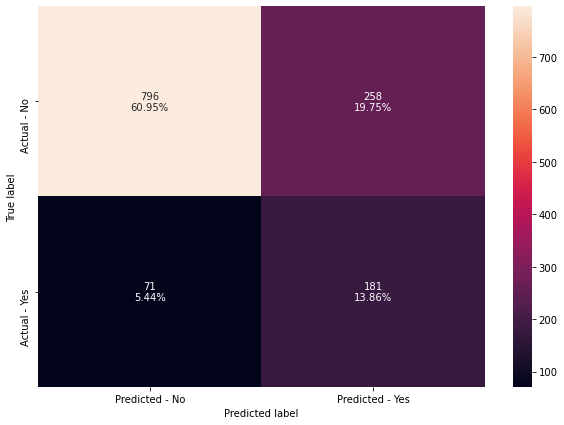

In [414]:
metrics_func(grid_bagging.best_estimator_, X_train, X_test, y_train, y_test)

conf_matrix(grid_bagging.best_estimator_, X_test, y_test)

In [415]:
models = [bagging, bagging_t]
met = []
for i in models:
    met.append(comp_func(i))
pd.DataFrame.from_records(met, columns=['Acc_Train', 'Acc_Test', 'Recall_Train', 'Recall_Test', 'Prec_Train', 'Prec_Test', 'F1_Train', 'F1_Test'], index = ['bagging', 'bagging_t'])

,Acc_Train,Acc_Test,Recall_Train,Recall_Test,Prec_Train,Prec_Test,F1_Train,F1_Test
bagging,0.836782,0.835375,0.313993,0.317460,0.659498,0.650407,0.425434,0.426667
bagging_t,0.751396,0.748086,0.755973,0.718254,0.419111,0.412301,0.539257,0.523878


    Improvement Discussion
    
We have the opposite problem with this model! We can notice  that our precision score has suffered quite the loss compared to our Decision Tree and Random Forest. However, from all of the models we have tried, this one is the one with least overfit as we mentioned befre. This is to be expected since the other models are both tree based and overfitting is an inherent characteristic of how they work and how they split the data. However, we are now doing worse than if we had just predicted the msot common class, thus, this model is not very useful. Of course, logistic regression is not commonly used in real world scenarios because of all the assumptions we have to make on the distribution of the data. We now see this in our results. Accuracy is actually now worse than just guessing the most common class, at 75 per cent. We were able to increase recall on testing set from 32 to 72 per cent, but this came at a cost of losing 20 percentage points in precision, which now stands at 41 pr cent. However, since the loss in precision was lower than the gain in recall, our F1 test has increased to 52 per cent. 

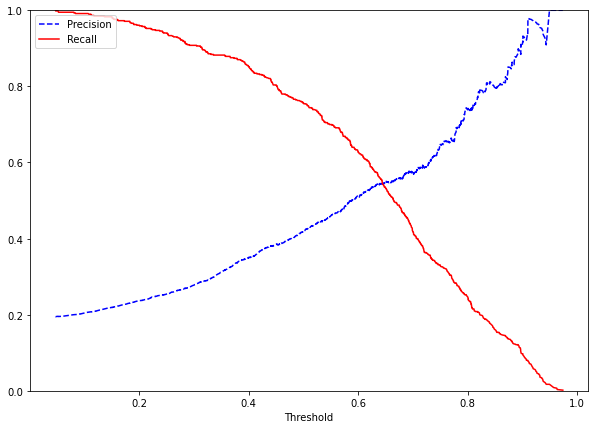

In [416]:
logr = grid_bagging.best_estimator_
# In order to select a threshold that maximizes precision, we can plot the recall and precision curves for each threshold
# from 0 to 1 and select the appropriate number. Notice that we could easily select a threshold very close to 1 and get
# almost perfect precision, but a model with recall 0 would not be very useful!
y_scores=logr.predict_proba(X_train)[:,1] # get all rows and second column
prec, rec, thre = precision_recall_curve(y_train, y_scores,)

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision') #plots precision curve on slash blue line
    plt.plot(thresholds, recalls[:-1], 'r', label = 'Recall') # plots recall curve on full red since it's the measure we
    plt.xlabel('Threshold')                                   # want to maximaize as we explained previously
    plt.legend(loc='upper left')
    plt.ylim([0,1])
plt.figure(figsize=(10,7))
plot_prec_recall_vs_tresh(prec, rec, thre)
plt.show()

In [417]:
# Change classfication threshold
pred_train_opt = (logr.predict_proba(X_train)[:,1]>.8)
pred_test_opt = (logr.predict_proba(X_test)[:,1]>.8)

In [419]:
print('Accuracy on train data:',accuracy_score(y_train, pred_train_opt) )
print('Accuracy on test data:',accuracy_score(y_test, pred_test_opt))

print('Recall on train data:',recall_score(y_train, pred_train_opt))
print('Recall on test data:',recall_score(y_test, pred_test_opt))

print('Precision on train data:',precision_score(y_train, pred_train_opt) )
print('Precision on test data:',precision_score(y_test, pred_test_opt))

print('F1 on train data:',f1_score(y_train, pred_train_opt) )
print('F1 on test data:',f1_score(y_test, pred_test_opt))

print('ROC-AUC Score on train data:',roc_auc_score(y_train, pred_train_opt) )
print('ROC-AUC Score on test data:',roc_auc_score(y_test, pred_test_opt))

Accuracy on train data: 0.8380952380952381
Accuracy on test data: 0.8292496171516079
Recall on train data: 0.24573378839590443
Recall on test data: 0.23412698412698413
Precision on train data: 0.7384615384615385
Precision on test data: 0.6629213483146067
F1 on train data: 0.3687580025608195
F1 on test data: 0.3460410557184751
ROC-AUC Score on train data: 0.612496825064158
ROC-AUC Score on test data: 0.6028319930122588


This is very interesting, notice that as we approach the same performance level of precision as the last two models, our level of recall also approaches a similar level as theirs. However, as mentioned above, the key difference between those models and this is that we avoid overfitting the training data. We were also able to stay above the 81 per cent threshold, so we did better! Precision increased almost 50 percent from .42 to 66 per cent. However, because this is nothing more than an exchange bewteen Recall and Precision, our F1 scsore suffered a loss to 35 per cent in testing data.

# Bagging - General Improvement
- Our decision tree and our Random Forest both suffer somewhat from overfitting. If I had decided to choose Decison Tree as estimator in our bagging classifier, it would most probably have the same problem. This is the nature of this type of algorithm. The decision tree also suffers from not being very stable, in fact, if we chose the orientation of our data by a little bit, the cuts made by the tree would be much different. The RF is much more stable in that sense.
- Our bagging classifier with logistic regression does not overfit the data but it has different kinds of problems. It's accuracy is too close to our 'pick most common class' threshold and that is bad news. We were able to achieve alright precision results with our tuned implementation though we went below that important threshols by a large margin.
- All thre of our models have trouble with Recall measure, not only because there exists a trade-off between Recall and precision, but because the models have trouble recognizing these differences in classes and thus, the true probability distribution of our data.
- The models could be potentially improve by adding useful features, but that is quite obvious! We also tried moving the threshold for logistic regression classification to increase precision, but the F1 score suffer a large loss when we did.

# Boosting Methods
# Adaboost

For the same reasons decribed above, our measure of performance will be F1 score with a specific ineterest on maximizing Precision to avoid as many FP as posible!

Accuracy on training set :  0.8502463054187193
Accuracy on test set :  0.8453292496171516
Recall on training set :  0.3890784982935154
Recall on test set :  0.376984126984127
Precision on training set :  0.6993865030674846
Precision on test set :  0.6785714285714286
F1 score on training set :  0.5
F1 score on test set :  0.4846938775510204


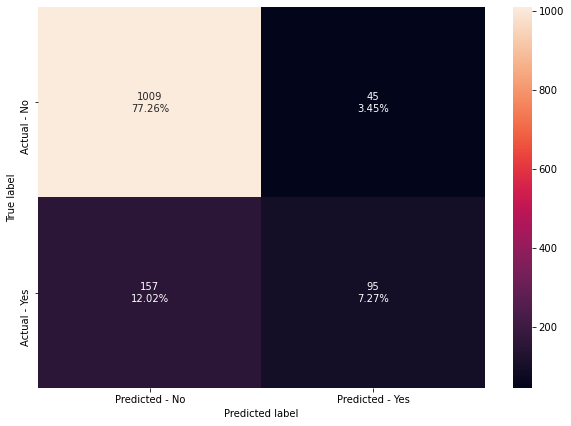

In [420]:
# We are now going to implement a set of boosting algorithms. Starting with Adaboost, which improves each subsequent model by changing the relative weights of misclassified examples in the dataset
# Moreover, it gives a higher weight to predictions made by models that perform better. Unlike gradient boosting, the algorithm focuses on the results of the previous model, while GBM works on the
# residuals of each previous model.

adb = AdaBoostClassifier(random_state=1)
adb.fit(X_train,y_train)

metrics_func(adb, X_train, X_test, y_train, y_test)

conf_matrix(adb, X_test, y_test)

Text(0.5, 0, 'AdaBoost Feature Importance')

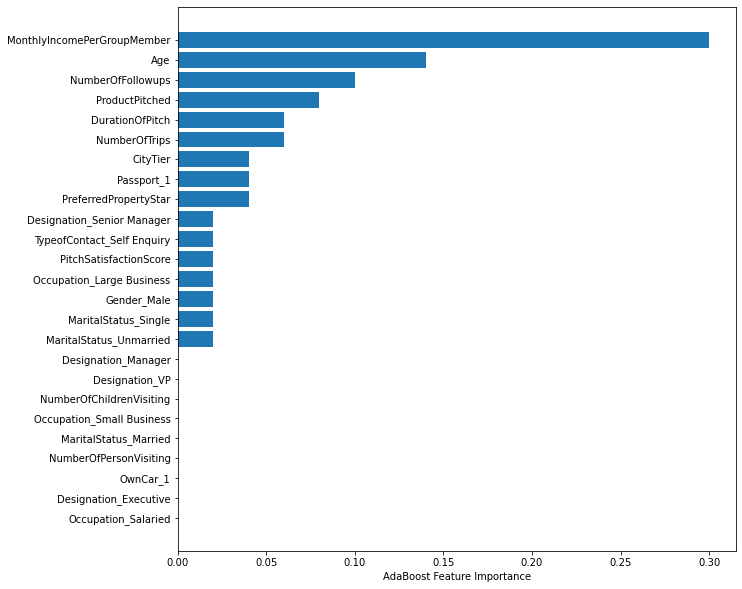

In [730]:
plt.figure(figsize=(10,10))
sorted_idx = adb.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], adb.feature_importances_[sorted_idx])
plt.xlabel("AdaBoost Feature Importance")

Our vanilla implementation of Adaptive Boosting does not seem to overfit the training data, which is great news. That is certainly an advantage over RF and Decision Tree. However, it does seem to perform similarly to our LogisticRegression classifier. We can see we are dangerously close the that threshold we spoke about. Let us see if we can improve the model by tuning some parameters! Both accuracy metrics are 85 per cent in testing and training set, and the pattern continous as we moved to other metrics. Recall on training set is a little bit higher on training set at .39 compared to .38 in testing set, but that is probaly just randomness. Precision is 70 per cent on test set and 68 on training set, whoch also corroborates the fact that the models does not overfit the data. Our metric of interest, F1 score, is not great, with both sets hovering around the 50 per cent mark. Let us now tune some hyperparameters!

Looking at our feature importance, the first thing we notice is that 9 features have no importance in our model. Some of them are DesignationExecutive, OccupationSalaried, OwnCar, MaritalSatusMarried, and of course, DesignationVP (which we have seen in our bagging models is always the least important feature. We also see that MaritalStatusUnmarried/Single, GenderMale, LargeBusiness Owner, PitchSatisfactionScore, SelfEnquiry and DesignationSeniorManager have the same importance weight at around 2 per cent. Unsurprinsgly, the most important feature by far is MonthlyIncomeperGroupMember at almost 30 per cent, followed by Age and then NumberofFollowUps.

# AdaBoost - Improvement

In [194]:
# We will now try some hyperparamter tuning and see if wee can improve our performance

adb_t = AdaBoostClassifier(random_state=25)

# Notice in base estimator we have to choose both the type of estimator and its mac depth, this can be learned from reading sci-kit's documentation
parameters = {
    "base_estimator":[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)], # First one is actually default estimator
    "n_estimators": np.arange(50,150,10),
    "learning_rate":np.arange(0.1,1.0, .05) # Also known as alpha
}


scorer = metrics.make_scorer(metrics.f1_score) #We are trying to maximize precision so we choose the appropriate scorer

# Run the grid search
grid_adb = RandomizedSearchCV(adb_t, parameters, scoring=scorer,cv=5, n_iter=20) # RandomizedGridSearch is much much faster than regular GS and performs similarly well
grid_adb = grid_adb.fit(X_train, y_train)

# Set best combination of parameters
adb_t = grid_adb.best_estimator_

# Fit the best algorithm to the data.
adb_t.fit(X_train, y_train)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.40000000000000013, n_estimators=140,
                   random_state=25)

Accuracy on training set :  0.9819376026272578
Accuracy on test set :  0.889739663093415
Recall on training set :  0.9180887372013652
Recall on test set :  0.6111111111111112
Precision on training set :  0.9871559633027523
Precision on test set :  0.77


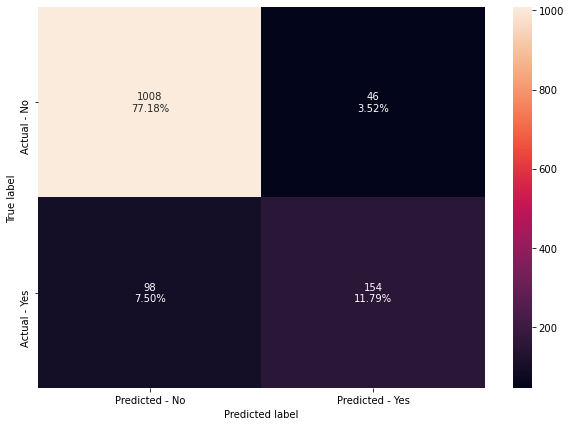

In [195]:
metrics_func(adb_t, X_train, X_test, y_train, y_test)

conf_matrix(adb_t, X_test, y_test)

In [421]:
models = [adb, adb_t]
met = []
for i in models:
    met.append(comp_func(i))
pd.DataFrame.from_records(met, columns=['Acc_Train', 'Acc_Test', 'Recall_Train', 'Recall_Test', 'Prec_Train', 'Prec_Test', 'F1_Train', 'F1_Test'], index = ['adb', 'adb_t'])

,Acc_Train,Acc_Test,Recall_Train,Recall_Test,Prec_Train,Prec_Test,F1_Train,F1_Test
adb,0.850246,0.845329,0.389078,0.376984,0.699387,0.678571,0.50000,0.484694
adb_t,0.981938,0.889740,0.918089,0.611111,0.987156,0.770000,0.95137,0.681416


Text(0.5, 0, 'AdaBoost Tuned Feature Importance')

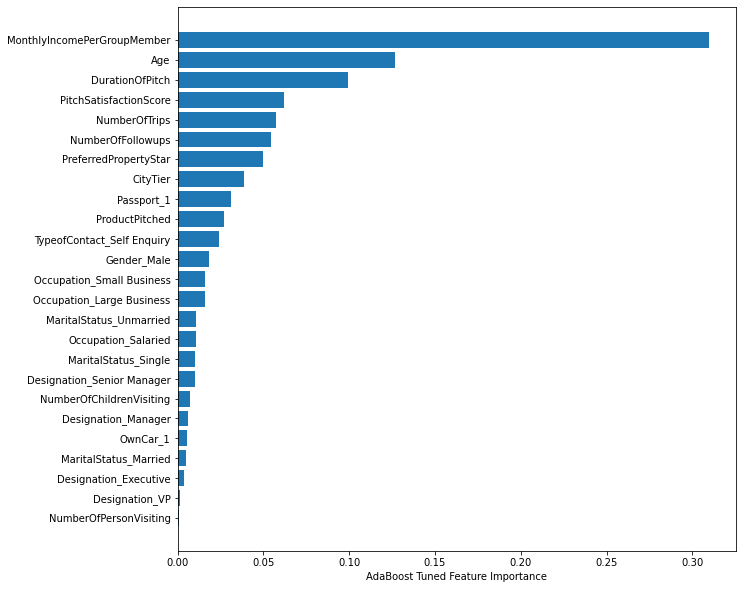

In [729]:
plt.figure(figsize=(10,10))
sorted_idx = adb_t.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], adb_t.feature_importances_[sorted_idx])
plt.xlabel("AdaBoost Tuned Feature Importance")

    Improvement Discussion

Wow, our gridsearch and hyperparamter tuning made a bigger difference here than in any of our previous examples. We can see accuracy was greatly increased, although it is clear our model now
overfits our data, which is the opposite problem from previous examples. Training accuracy is .98 now but testing is at .89 This is noticeable in all three of our metrics but more so in our Recall, where training data achieved .92 but testing decaresed all the way to 61 per cent. This is not unexpected, as all of our models are having trouble dealing with that specific metric. Our metric of choice, F1, has increased from 48 per cent to 68 per cent, i'll take that! This was probably due to the fact that precision on training set increased to 99 per cent and 77 per cent in testing data. While our model overfits the data, it still performs well on unseen examples.

- From the point of view of feature importance, our model has selected MonthlyIncomePerGroupMember as it's most important feature. Around 30 pre cent of total importance is given to this attribute. The next feature only has 13 per cent. In fact, those two features account for almost 50 per cent of all relative importance in our model. At the end of the list we can Designations, Marital Status and Car ownership. This is striking as Passport, which I thought would be the one of the most, if not the most important feature is quite low in the list, with less than 5 per cent importance. It will be interesting to see what the other boosting algorithms say.

In [620]:
adb_manual = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.1, n_estimators=200,
                   random_state=25)
adb_manual.fit(X_train, y_train)
metrics_func(adb_manual, X_train, X_test, y_train, y_test)

Accuracy on training set :  1.0
Accuracy on test set :  0.9218989280245024
Recall on training set :  1.0
Recall on test set :  0.6626984126984127
Precision on training set :  1.0
Precision on test set :  0.907608695652174
F1 score on training set :  1.0
F1 score on test set :  0.7660550458715596


Fot sake of example, in the above cell I have tried manual model improvement. However, while I was able to achieve higher F1 score, I have also ended up overfitting the dataset even more than our RandomGridSearch. This comes to show GridSearch is the most efficient way of improving our models!

# Gradient Boosting

In [196]:
# We will now fit a gradient boosting algorithm to our data. Our model will now fit subsequent trees to the residuals of the the tree before it. Let us see how it compares to our Adaboost model
gb = GradientBoostingClassifier(random_state=50)
gb.fit(X_train,y_train)

GradientBoostingClassifier(random_state=50)

Accuracy on training set :  0.8889983579638752
Accuracy on test set :  0.8637059724349158
Recall on training set :  0.4812286689419795
Recall on test set :  0.3888888888888889
Precision on training set :  0.8924050632911392
Precision on test set :  0.8032786885245902
F1 score on training set :  0.6252771618625277
F1 score on test set :  0.5240641711229947


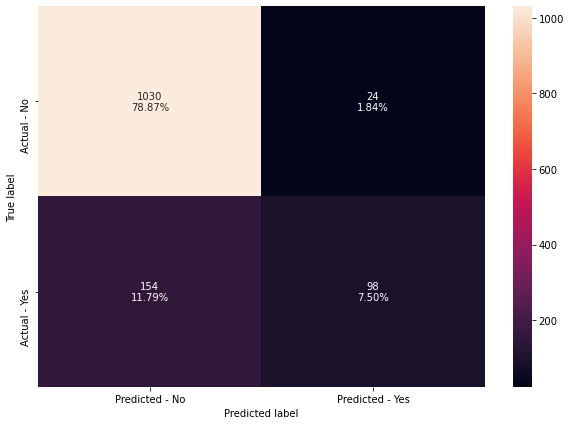

In [422]:
metrics_func(gb, X_train, X_test, y_train, y_test)

conf_matrix(gb, X_test, y_test)

Text(0.5, 0, 'GradientBoosting Feature Importance')

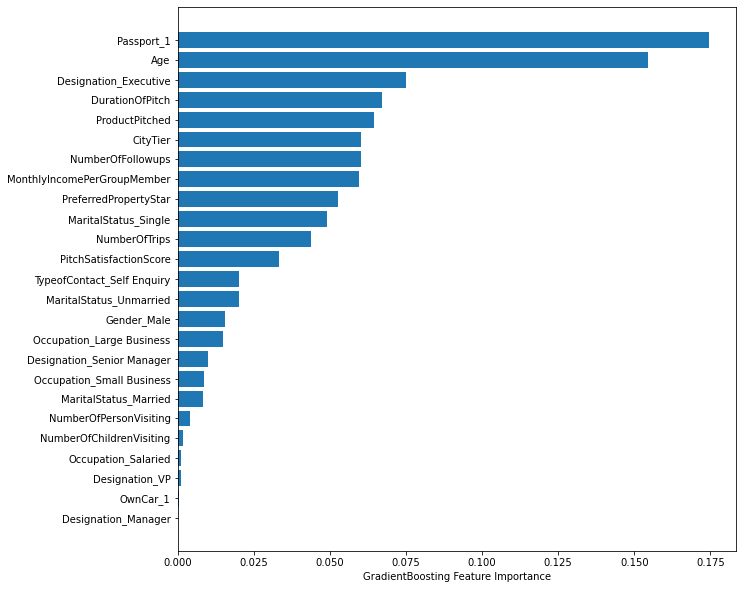

In [731]:
plt.figure(figsize=(10,10))
sorted_idx = gb.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], gb.feature_importances_[sorted_idx])
plt.xlabel("GradientBoosting Feature Importance")

I would say this is the best vanilla model thus far. We are still overfitting the data a little bit when we look at precision on both datasets, but accuracy is rather similar in both, 89 per cent and 86 per cent, respectively. The Gradient Bossting also did better on our Achille's hill metric, Recall, achieving 48 per cent in training and .39 in testing data. I have high hopes the tuned version will perform very well once tuned. We see our metric of choice, F1 hovering at 63 per cent on training and 53 on testing data, however, if we compound that with the fact we are achieving good Precision, at 80 per cent on testing data, then we can conclude the model performs alright. Remember our metric of choice is indeed F1, however, the next most important metric we are looking at is Precision because of the high marketing costs.

Regarding feature importance in our Gradient Boosting model, we can see in this case that Passport is the most important feature, followed closely by Age. Combined, they account for 33 per cent of all feature importance. After those two, we see a large decrease in the next feature, wich is DesignationExecutive and which has a relative importance of 8 per cent, so almost half of our first two features. DurationOfPitch, ProductPitc, CityTier, NumberOfFollowUps have a similar weight, at around 7 per cent. Unsurpisngly, we see the same features at the end of the chart as we have been noting before, DesignationManager, OwnCar, NumberOfPersonVisiting and DesignationVP (although not at the end this time!). 

# Gradient Boosting - Improvement

In [198]:
gb_t = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=12),random_state=8)

# Grid of parameters to choose from
parameters = {
    'max_depth': np.arange(1,5,1), # Max depth of stubs
    "learning_rate":np.arange(0.1,1.0,.05), # Model's learning rate, lower rate helps with overfitting
    "subsample":[0.5,0.7, .8, .9, 1], # The fraction of samples to use in the training of each stub
    "n_estimators": np.arange(100,300,10), # Same hyperparamter than in RF and Bagging, how many stubs to use
    "max_features":[0.7,0.8,0.9,1],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_gb = RandomizedSearchCV(gb_t, parameters, scoring=scorer,cv=5, n_iter=20)
grid_gb = grid_gb.fit(X_train, y_train)


gb_t = grid_gb.best_estimator_
gb_t.fit(X_train, y_train)


GradientBoostingClassifier(init=AdaBoostClassifier(random_state=12),
                           learning_rate=0.6000000000000002, max_depth=4,
                           max_features=0.7, n_estimators=140, random_state=8,
                           subsample=0.9)

Accuracy on training set :  1.0
Accuracy on test set :  0.9088820826952527
Recall on training set :  1.0
Recall on test set :  0.6706349206349206
Precision on training set :  1.0
Precision on test set :  0.824390243902439


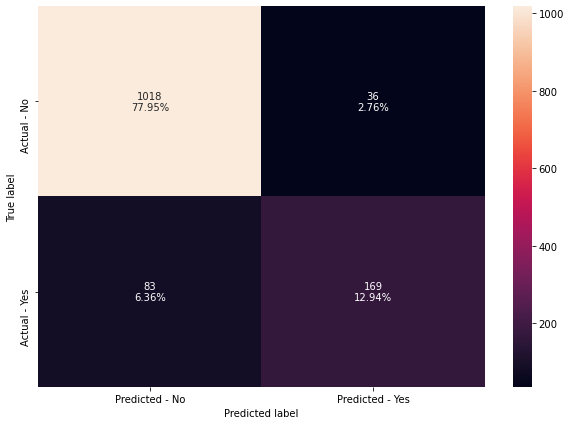

In [199]:
metrics_func(gb_t, X_train, X_test, y_train, y_test)

conf_matrix(gb_t, X_test, y_test)

In [425]:
models = [gb, gb_t]
met = []
for i in models:
    met.append(comp_func(i))
pd.DataFrame.from_records(met, columns=['Acc_Train', 'Acc_Test', 'Recall_Train', 'Recall_Test', 'Prec_Train', 'Prec_Test', 'F1_Train', 'F1_Test'], index = ['gb', 'gb_t'])

,Acc_Train,Acc_Test,Recall_Train,Recall_Test,Prec_Train,Prec_Test,F1_Train,F1_Test
gb,0.888998,0.863706,0.481229,0.388889,0.892405,0.803279,0.625277,0.524064
gb_t,1.000000,0.908882,1.000000,0.670635,1.000000,0.824390,1.000000,0.739606


Text(0.5, 0, 'GradientBoosting Feature Importance')

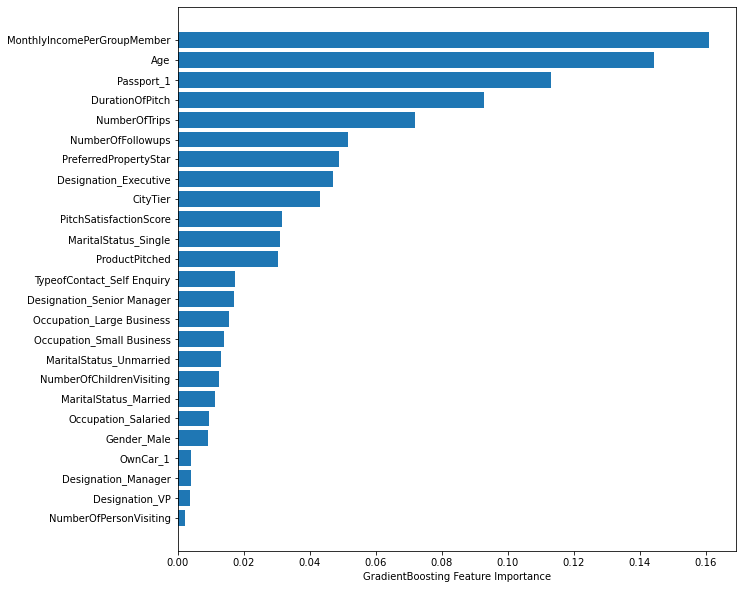

In [718]:
plt.figure(figsize=(10,10))
sorted_idx = gb_t.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], gb_t.feature_importances_[sorted_idx])
plt.xlabel("GradientBoosting Tuned Feature Importance")

    Improvement Discussion

Our tuned Gradient Boosting model certainly does much better than the vanilla implementation, however we have uncovered a second problem, it is now overfitting the data by a relatively large margin! The largest differnece is in our Recall, as we would expect from previous experiences, we get perfect Recall on training set but is lowered all the way to 67 on unseen data. However we have increased Precison to 82 per cent and Recall stayed at an acceptable 67 per cent. All in all, this model could be improved if we lower the max_depth of our estimators, since that helps with overfitting. Notice our tuned version has a max_depth of 4 for each estimator! Due to that loss we experienced in Recall, even with the improvement in Precision, our model only acheives 74 per cent on F1 metric. However, similarly to our adaboost model, there is too much variance between the scores, and this model would probably not be veru reliable in the real world.

- Looking at feature importance, we can see in first place the same as in AdaBoost, MonthlyIncomePerGroupMember followed by age. However, notice that adaboost contributed almost 1/3 of all importance to Income, while Gradient Boosting only gives it 16 per cent, age gets 15 per cent. It is also peculiar that in this case, whether the person has a passport or not, contributes much more than in the previous model. Here, Passport feature gets 11 per cent relative importance. We find similar rates given to the lowest features and find again NumberOfPersonsVisiting, VP Designation and whether the person has a car or not. I can see weights are more evenly distributed than in our AdaBoost model.

# XGBoost

In [200]:
# Let us now try the XGBoost algorithm, which is a highly optimized version of vanilla gradient boosting, as see how we do!

xgb = XGBClassifier(random_state=45, eval_metric='logloss')
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=45, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

Accuracy on training set :  0.999671592775041
Accuracy on test set :  0.9372128637059725
Recall on training set :  0.9982935153583617
Recall on test set :  0.7301587301587301
Precision on training set :  1.0
Precision on test set :  0.9292929292929293
F1 score on training set :  0.9991460290350128
F1 score on test set :  0.8177777777777778


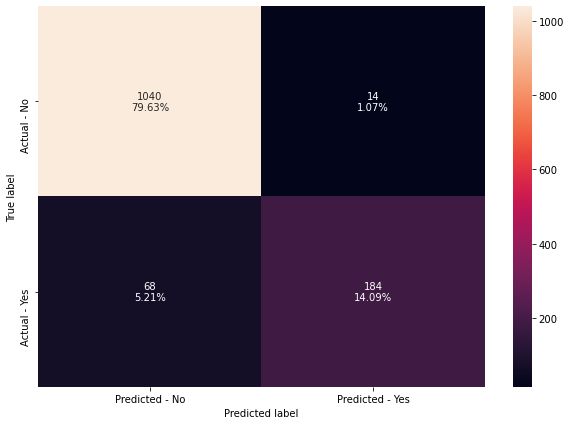

In [424]:
metrics_func(xgb, X_train, X_test, y_train, y_test)

conf_matrix(xgb, X_test, y_test)

Text(0.5, 0, 'Xgboost Feature Importance')

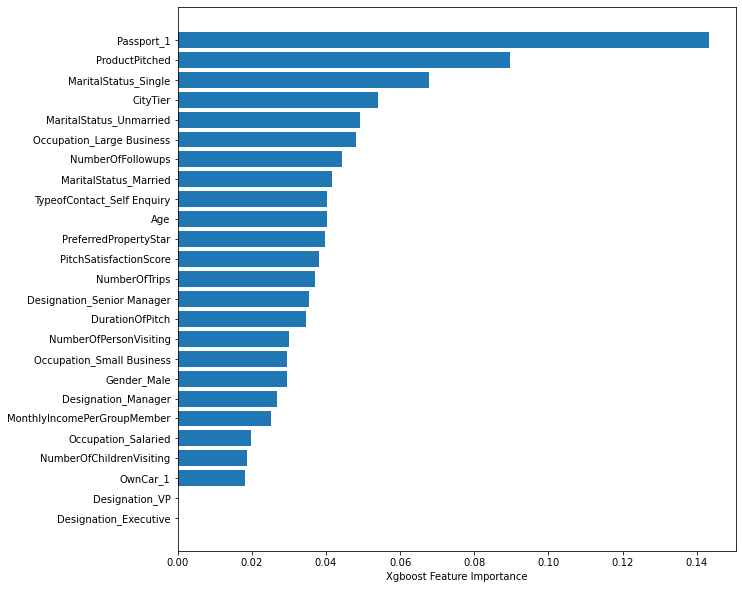

In [732]:
plt.figure(figsize=(10,10))
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

As one would expect, our xgboost implementation, even before any type of hyperparameter tuning, is the model that has acheived the best performance. We do still experience a degree of overfitting, and it is most noticeable in our Recall metric, where training data acheives .99 but testing is lower at .73. Perhaps some hp tuning will allow us to reduce overfitting while maintaining the performance from the vanilla implementation. Let us see how we do! Accuracy is pretty good in both training and testing, with 99 per cent and 94 per cent, this, again, shows some overfitting. Precision is great at 93 per cent, which is extremely useful in our case because of the reasons already mentioned. Notice an F1 score of 82 per cent. As with previous models, the main issue with boosting is that overfit, and the fact that results in the real world could have great variance and not be reliable for real business use.

Interesting to see that, by far, the most important feature for XGBoost is whether the person has a passport or not. This accounts for 14 per cent of all realtive importance. Next we have ProductPitched, at arounf 10 per cent. We also notice MaritalStatusSingle ad the third most important feature, a change from previous model where it had not been seen in top three features. From there we start seeing a constant decrease of importance from CityTier, with 6 per cent all the way down to DesignationExecutive and Vp, which again, show 0 importance in our model. Of course none of this should surpise us since we did run VIF analysis (even if these models don't require us to remove highly correlated features) and notices Jobdesignations had a high value (INF).

# XGBoost - Improvement

In [202]:
# By now, this next chunk of code should be familiar. We initialize a second model, and then choose different hyperparameters before parsing it through our RandomGridSearch. Finally, we
# select the set of hp that maximize our metric of choice.

xgb_t = XGBClassifier(random_state=45, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "eta": np.arange(.1,1.0,.05), # This is the parameter for learning rate, or alpha. Lower eta will help with overfitting
    "gamma": np.arange(0,1.0,.05), # A larger gamma will help with overfitting, minimun loss reduction accepted to perform a split
    "n_estimators": [15,30,45], # Same as previous algorithms, how many estimators to include in model
    "max_depth": [2,4,6,8,10], # Max depth of stubs
    "scale_pos_weight":[1,2,5], # Controls weights when classes are unbalance
    "subsample":[0.5,0.75,1],
    "colsample_bytree":[0.5,0.75,1],
    "colsample_bylevel":[0.5,0.75,1] # The last three parameters control how many columns to use in each split
}

scorer = metrics.make_scorer(metrics.f1_score)


grid_xgb = RandomizedSearchCV(xgb_t, parameters,scoring=scorer,cv=5, n_iter = 100)
grid_xgb = grid_xgb.fit(X_train, y_train)


xgb_t = grid_xgb.best_estimator_

# While we always refit the data because of how our performance function is written, by running this last step we get to see the best hp printed on screen
xgb_t.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75,
              eta=0.30000000000000004, eval_metric='logloss', gamma=0.45,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=45, n_jobs=8, num_parallel_tree=1, random_state=45,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Accuracy on training set :  1.0
Accuracy on test set :  0.9295558958652373
Recall on training set :  1.0
Recall on test set :  0.7698412698412699
Precision on training set :  1.0
Precision on test set :  0.8508771929824561


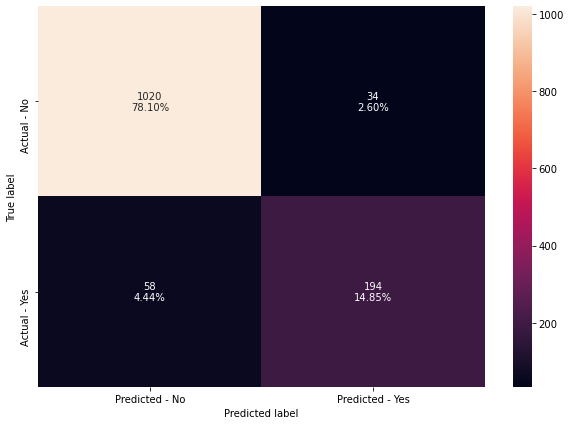

In [203]:
metrics_func(xgb_t, X_train, X_test, y_train, y_test)

conf_matrix(xgb_t, X_test, y_test)

Text(0.5, 0, 'Xgboost Feature Importance')

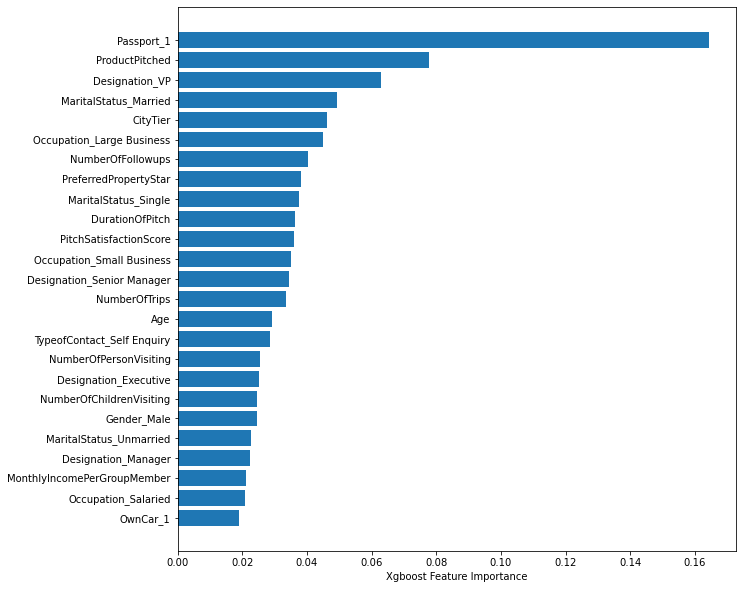

In [252]:
plt.figure(figsize=(10,10))
sorted_idx = xgb_t.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], xgb_t.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Tuned Feature Importance")

In [426]:
models = [xgb, xgb_t]
met = []
for i in models:
    met.append(comp_func(i))
pd.DataFrame.from_records(met, columns=['Acc_Train', 'Acc_Test', 'Recall_Train', 'Recall_Test', 'Prec_Train', 'Prec_Test', 'F1_Train', 'F1_Test'], index = ['xgb', 'xgb_t'])

,Acc_Train,Acc_Test,Recall_Train,Recall_Test,Prec_Train,Prec_Test,F1_Train,F1_Test
xgb,0.999672,0.937213,0.998294,0.730159,1.0,0.929293,0.999146,0.817778
xgb_t,1.000000,0.929556,1.000000,0.769841,1.0,0.850877,1.000000,0.808333


    Improvement Discussion

Our hyperparameter tuning helped increase Recall by a fraction of the original values from .73 to .77, however, it was rather a tradeoff between precison and recall (as is always the case in machine learning). We notice Precision dropped from .93 to .85, so almost a one to one exchange. Our model still overfits the data a little bit but again, compared to all of our other models, this one does the best. Moreover, since XGB can perform its training in parallel, the GridSearch takes cosniderably less time than with other models, which is something we might have to consider aas pur training sets get larger. F1 score remained rather unchanged at 81 per cent, and this is due to the fact we increased recall but lowered precision. If I were to decide which model to implement, I would go for the untuned version since I rather have higher precision than recall, it would probably cost me less as a compnay to do this.
- We can take a look at the feature importance in our model. Clearly, passport is the one with highest relative importance, we've explained already why this is the case. We se though, that right after that we have ProductPitched, which is a surprise for me since we noted the distributions to be similar in both groups. On third place we have whether the individual is a VP or not, followed by their marital status. Notice how the importance of Passport started at a relatively low point in AdaBoost, increased somewhat in GradientBoosting and in XGBoost has become the most important feature. Also notice that one of the least important feature in the previous two boosting algorithms has become the second most important, Designation_VP. And one of the most important features has taken a back seat in XGBoost, that being Age.


# Stacking

In [206]:
# In our final model, we will use the predictions of previous models to create a more robust (hopefully) model. The predictions are passed to a final model before providing us with a result.
# We will use our top performing models

estimators = [('Gradient Boosting', gb_t), ('AdaBoost', adb_t), ('Random Forest',grid_rf )] # List of tuples with our selected classifiers

final_estimator = xgb_t

stacking_m = StackingClassifier(estimators=estimators,final_estimator=final_estimator)

stacking_m.fit(X_train,y_train)

StackingClassifier(estimators=[('Gradient Boosting',
                                GradientBoostingClassifier(init=AdaBoostClassifier(random_state=12),
                                                           learning_rate=0.6000000000000002,
                                                           max_depth=4,
                                                           max_features=0.7,
                                                           n_estimators=140,
                                                           random_state=8,
                                                           subsample=0.9)),
                               ('AdaBoost',
                                AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                                   learning_rate=0.40000000000000013,
                                                   n_est...
                                                 gamma=0.45, gpu_id=-1,
           

Accuracy on training set :  0.9970443349753695
Accuracy on test set :  0.9196018376722818
Recall on training set :  0.9948805460750854
Recall on test set :  0.75
Precision on training set :  0.9898132427843803
Precision on test set :  0.8181818181818182
F1 score on training set :  0.9923404255319148
F1 score on test set :  0.7826086956521738


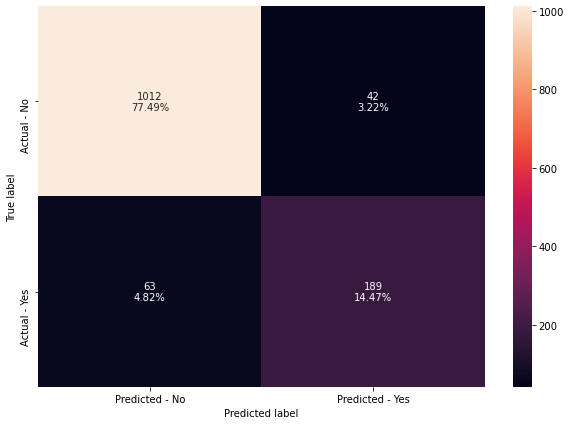

In [427]:
metrics_func(stacking_m, X_train, X_test, y_train, y_test)

conf_matrix(stacking_m, X_test, y_test)

- Our stacking model performs quite similarly to our tuned XGBoost. This is to be expected since most of algorithms performed similar in the sense that their precision was acceptable but they all had trouble with Recall metric. We have a slight overfit of the model, consdiering accuracy on training set was almost 1.0 but on testing set was 92 per cent. Again, Recall has the highest difference of all metrics, moving from 99 per cent to .75. However, the good news is that precision is pretty good at 82 per cent and thus, F1 score is also good at 78 per cent. But it also shows signs of overfiting since F1 score on testing set is 99 per cent.
- I theorize this is because the relationships between our varibales were too complex for our models to capture, to test this hypothesis, I implemented a simple multilayer perceptron with only two hidden layers. It not only did not overfit the data as much as our best performing model (XGBoost), but it did very well in our metric of choice, which is recall. Of course, this is a very simple implementation of a neural network, but we shall re-visit this algorithm in the future and tinker more deeply with it!

# Boosting Improvement (General)
- We notice similar problems with out Boositng algorithms compared to our bagging algorithms. They both had a difficult time achieving a high level of Recall.
- All vanilla implementations did much better than the vanilla implementation of the bagging algorithms.
- As with all preceding models, we chose to maximize f1 score because if we had chosen precision, recall would have dropped to unacceptable levels below 25 per cent. While we are interested in maximizing Precision over Recall, we have to consider the practical, real-world use of our models.
- XGBoost did the best our of all of our models, including stacking, and its popularity is well-earned.. It not only over performed, but it was the fastest to train of all boosting algorithms thanks to its ability to work in parallel.
- As mentioned above, in order for our models to do better, we would have to find better features. Our EDA showed most values were pretty similar amongst the two groups (those who took the package and those who didn't), so even at that point I knew it would be difficult for our models to discern between the two.
- Notice that unlike the tuned versions of our bagging classifiers, when we changed the hyperparameters in the Boosting algorithms, we tended to overfit the data, exemplified by the large discrepancies between testing and training accuracy, recall, precision and F1 score. However, it is also important to notice the large improvement in precision, which after F1 score, is our preferred metric of choice.

In [208]:
clf = MLPClassifier(solver='lbfgs', alpha=.0005,
                     hidden_layer_sizes=(20, 10), random_state=1)

clf.fit(X, y)

MLPClassifier(alpha=0.0005, hidden_layer_sizes=(20, 10), random_state=1,
              solver='lbfgs')

Accuracy on training set :  0.948768472906404
Accuracy on test set :  0.9494640122511485
Recall on training set :  0.8003412969283277
Recall on test set :  0.7936507936507936
Precision on training set :  0.9232283464566929
Precision on test set :  0.9345794392523364


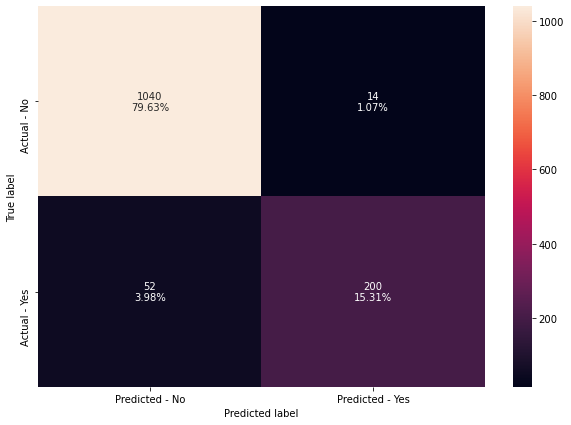

In [216]:
metrics_func(clf, X_train, X_test, y_train, y_test)

conf_matrix(clf, X_test, y_test)

As expected, a simple neural network works wonder with this data which portrays complex relationships!

In [722]:
models = [dt, dt_tuned, rf, rf_t, bagging, bagging_t, adb, adb_t, gb, gb_t, xgb, xgb_t, stacking_m]
met = []
for i in models:
    met.append(comp_func(i))
    
df_total_scores = pd.DataFrame.from_records(met, columns=['Acc_Train', 'Acc_Test', 'Recall_Train', 'Recall_Test', 'Prec_Train', 'Prec_Test', 'F1_Train', 'F1_Test'], 
                          index = ['dt', 'dt_tuned', 'rf', 'rf_t', 'bagging', 'bagging_t', 'adb', 'adb_t', 'gb', 'gb_t', 'xgb', 'xgb_t', 'stacking_m'])
df_total_scores.sort_values(by='F1_Test', ascending=False)

,Acc_Train,Acc_Test,Recall_Train,Recall_Test,Prec_Train,Prec_Test,F1_Train,F1_Test
xgb,0.999672,0.937213,0.998294,0.730159,1.000000,0.929293,0.999146,0.817778
xgb_t,1.000000,0.929556,1.000000,0.769841,1.000000,0.850877,1.000000,0.808333
rf_t,0.999015,0.925727,1.000000,0.718254,0.994907,0.874396,0.997447,0.788671
dt,1.000000,0.909648,1.000000,0.781746,1.000000,0.757692,1.000000,0.769531
stacking_m,0.987192,0.902757,0.993174,0.781746,0.943274,0.732342,0.967581,0.756238
gb_t,1.000000,0.908882,1.000000,0.670635,1.000000,0.824390,1.000000,0.739606
rf,1.000000,0.911179,1.000000,0.579365,1.000000,0.935897,1.000000,0.715686
adb_t,0.981938,0.889740,0.918089,0.611111,0.987156,0.770000,0.951370,0.681416
gb,0.888998,0.863706,0.481229,0.388889,0.892405,0.803279,0.625277,0.524064
bagging_t,0.751396,0.748086,0.755973,0.718254,0.419111,0.412301,0.539257,0.523878


We notice untuned XGBoost is our best performer, followed by its tuned version. Interestingly enough, in third place we have random forest and not any other of the boosting algorithms. This shows that bagging has its place in machine learning and does perform well even with difficult data. What is even more intersting is that our simple decision tree came in fourth place, bust we must take into cosnideration the overfit it has. If we are looking for reliability, we could consider gradient boosting instead, since bagging_tuned is below our important threshold of 81 per cent, and that is definitely not acceptable in a business scenario. One of the main reasons I proposed tuned Gradient Boosting before Stacking, even if it performed 3 per cent better, is the fact that Stacking required us to train and then tune three models before we could test it. Even if we used RandomGridSearch, it took a considerable amount of time before we could implement our stacking model. For this reason, I find it more efficient to propose the use of tuned GB instead of our Stacking model.

# Actionable Insight

- First and foremost, the model of choice for this task is certainly XGBoost, stakeholders would probably say tuned because it will generalize better to unseen data. However, this is a matter of weighing the pros and cons of each model. We notice that tuned bagging models do not perform as well as boosting, but they tend to generalize better. One could weigh in the fact that they require very reliable predictions instead of very accurate predictions, however, if it were up to me, I would go with XGBoost untuned simply because even if there exists some variance between testing and training sets, its precision is far greater than previous model implementations and its tuned version.
- The company should focus in marketing efforts towards younger rather than older individuals according to our EDA (and the fact that age plays such and important feature (high importance) in most of our models). Also, it might seem counter-intuitive, but our EDA also shows a lower wage is associated with a higher probability of accepting the package, we know too that the Basic package is highly preferred over the other 4 so this is important to consider. 3 stars hotels should make the bulk of the options offered to customers since an overhwhelming percentage of individuals seem to prefer this tier.
- As exemplified by our EDA and later by the importance given to features in our Decision Tree, the company should also focus in people who already have a passport. If the new package is 'Wellness Tourism', I assume the company would take customers to a nice beach or somewhere far, far away from the pollution of the cities. The best beaches are known to be in the Caribbean or South Asia, so they'll need to have a passport in hand.
- The company should also focus on individuals from city Tiers 1, since they are the ones most probable to take the package.
- Moreover, they should train their agents to give longer, and more detailed pitches as well as follow-up with the client at least 3 times, since this 2 actions combined are as important as age.
- From feature importance in our best model (XGBoost) we also find that the productr that was pitched also plays an important part on whether or not the trip was accepted. This makes sense, as in most cases, whether we grouped by city tier, passport, or even profession, the Basic package was preferred over 50 per cent of the time. If the company wants to sell their Wellness package, they must offer it at a competitive price. This, of course, is the law of supply and demand in the works!
- We note the totality of individuals' gender is 60 male vs 40 female, but once we drill down into it, we find that from the cohort that accepted the offer, 64 were male vs only 36 female. The company could use this information in two ways, either lock down on males or expand their marketing type to attract more female customers, which, in the long run, will be more benefitial for bsuiness growth.